<h1>NR-ER</h1>

In [ ]:
#Da far andare su Colab
from google.colab import drive
drive.mount('/content/drive')

!ls "/content/drive/My Drive/dati_AML"

!pip install gpyopt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
hyp_1.txt		    NR-ER_wholetraining_x.txt
hyp_2.txt		    NR-ER_wholetraining_y.txt
hyp_4.txt		    SR-ARE_score_x.txt
hyp_5.txt		    SR-ARE_score_y.txt
hyp_6.txt		    SR-ARE_test_x.txt
NR-AhR_score_x.txt	    SR-ARE_test_y.txt
NR-AhR_score_y.txt	    SR-ARE_train_x.txt
NR-AhR_test_x.txt	    SR-ARE_train_y.txt
NR-AhR_test_y.txt	    SR-ARE_wholetraining_x.txt
NR-AhR_train_x.txt	    SR-ARE_wholetraining_y.txt
NR-AhR_train_y.txt	    SR-MMP_score_x.txt
NR-AhR_wholetraining_x.txt  SR-MMP_score_y.txt
NR-AhR_wholetraining_y.txt  SR-MMP_test_x.txt
NR-ER_score_x.txt	    SR-MMP_test_y.txt
NR-ER_score_y.txt	    SR-MMP_train_x.txt
NR-ER_test_x.txt	    SR-MMP_train_y.txt
NR-ER_test_y.txt	    SR-MMP_wholetraining_x.txt
NR-ER_train_x.txt	    SR-MMP_wholetraining_y.txt
NR-ER_train_y.txt


In [ ]:
#Import

import json

import numpy as np
from numpy.random import seed
seed(1234)


import GPyOpt

import seaborn as sbn

from imblearn.over_sampling import RandomOverSampler

import collections

from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

import tensorflow as tf

from imblearn.over_sampling import SMOTENC

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Conv2D, Input
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import sklearn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.utils import class_weight

Using TensorFlow backend.


In [ ]:
#Train-Validation

with open('/content/drive/My Drive/dati_AML/NR-ER_wholetraining_x.txt', 'r') as f:
    NR_ER_wholetraining_x = json.loads(f.read())

with open('/content/drive/My Drive/dati_AML/NR-ER_wholetraining_y.txt', 'r') as f:
    NR_ER_wholetraining_y = json.loads(f.read())

X = np.array(NR_ER_wholetraining_x)
Y = np.array(NR_ER_wholetraining_y)

#Score

with open('/content/drive/My Drive/dati_AML/NR-ER_score_x.txt', 'r') as f:
    NR_ER_score_x = json.loads(f.read())

with open('/content/drive/My Drive/dati_AML/NR-ER_score_y.txt', 'r') as f:
    NR_ER_score_y = json.loads(f.read())

NR_ER_score_x = np.array(NR_ER_score_x)
NR_ER_score_y = np.array(NR_ER_score_y)

In [ ]:
#Def funzioni

def metrics():

    METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc')]
  
    return(METRICS)

def plot_auc(history):
    fig, ax1 = plt.subplots()
    ax1.plot(history.epoch, history.history['auc'],c='b', label="Train")
    ax1.plot(history.epoch, history.history['val_auc'],c='g', label="Val")
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('AUC')
    plt.legend()
    plt.show()

def plot_rec(history):
    fig, ax1 = plt.subplots()
    ax1.plot(history.epoch, history.history['recall'],c='b', label="Train")
    ax1.plot(history.epoch, history.history['val_recall'],c='g', label="Val")
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Recall')
    plt.legend()
    plt.show()
    
def plot_prec(history):
    fig, ax1 = plt.subplots()
    ax1.plot(history.epoch, history.history['precision'],c='b', label="Train")
    ax1.plot(history.epoch, history.history['val_precision'],c='g', label="Val")
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Precision')
    plt.legend()
    plt.show()
    

def plot_loss(history):
    fig, ax1 = plt.subplots()
    ax1.plot(history.epoch, history.history['loss'],c='b', label="Train")
    ax1.plot(history.epoch, history.history['val_loss'],c='g', label="Val")
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('LOSS')
    plt.legend()
    plt.show()

<h1>Modelli</h1>

Viene effettuata un'analisi esplorativa, attraverso l'applicazione di diverse architetture, al fine di identificare i parametri che influenzano maggiormente le performances.

<h3>Modello 1<h3>

In [ ]:
kfold = StratifiedKFold(n_splits=3, shuffle=True)
#train scores
cvscores_train_loss = []
cvscores_train_auc = []
cvscores_train_rec = []
cvscores_train_prec = []

#validation scores
cvscores_val_loss = []
cvscores_val_auc = []
cvscores_val_rec = []
cvscores_val_prec = []

for train, test in kfold.split(X, Y):
    
    modello = Sequential()
    modello.add(Conv1D(100, kernel_size=(10), activation='relu', padding = 'same'))
    modello.add(keras.layers.GlobalMaxPooling1D())
    modello.add(Dense(64, activation = 'relu'))
    modello.add(Dropout(0,5))
    modello.add(Dense(1, activation='sigmoid'))

    early_stopping = EarlyStopping(
                                  monitor='val_loss', min_delta=0, patience=40, verbose=0, mode='auto',
                                  baseline=None, restore_best_weights=True)


    modello.compile(loss=keras.losses.BinaryCrossentropy(),optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=metrics())

    history = modello.fit(X[train], Y[train],
                        batch_size=256,
                        epochs=80,
                        verbose=1,
                        callbacks = [early_stopping],
                        validation_data = (X[test], Y[test])) 
    
    cvscores_train_loss.append(history.history['loss'][-1])
    cvscores_train_auc.append(history.history['auc'][-1])
    cvscores_train_rec.append(history.history['recall'][-1])   
    cvscores_train_prec.append(history.history['precision'][-1])

    cvscores_val_loss.append(history.history['val_loss'][-1])
    cvscores_val_auc.append(history.history['val_auc'][-1])
    cvscores_val_rec.append(history.history['val_recall'][-1])   
    cvscores_val_prec.append(history.history['val_precision'][-1])

print("Loss: ",np.mean(cvscores_val_loss),' +/- ' ,np.std(cvscores_val_loss))
print("AUC: ",np.mean(cvscores_val_auc),' +/- ',np.std(cvscores_val_auc))
print("Recall: ",np.mean(cvscores_val_rec),' +/- ',np.std(cvscores_val_rec))
print("Precision: ",np.mean(cvscores_val_prec),' +/- ',np.std(cvscores_val_prec))


Train on 4304 samples, validate on 2153 samples
Epoch 1/80
4304/4304 [==============================] - 1s 337us/step - loss: 0.3963 - tp: 18.0000 - fp: 184.0000 - tn: 3661.0000 - fn: 441.0000 - accuracy: 0.8548 - precision: 0.0891 - recall: 0.0392 - auc: 0.4834 - val_loss: 0.3376 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1923.0000 - val_fn: 230.0000 - val_accuracy: 0.8932 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6359
Epoch 2/80
4304/4304 [==============================] - 1s 250us/step - loss: 0.3248 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 3845.0000 - fn: 459.0000 - accuracy: 0.8934 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6459 - val_loss: 0.3134 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1923.0000 - val_fn: 230.0000 - val_accuracy: 0.8932 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6975
Epoch 3/80
4304/4304 [==============================] - 1s 243us/step - loss: 0.3016 - tp: 0.0000e+00 - fp: 0.0000e+00 - 

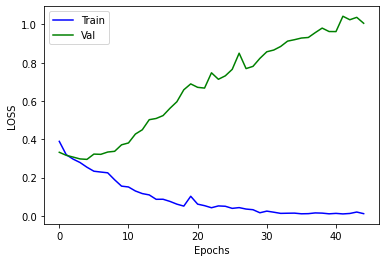

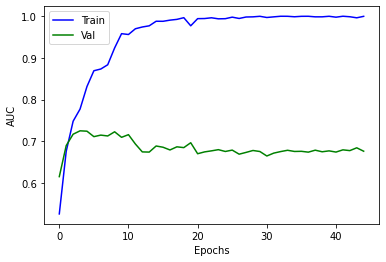

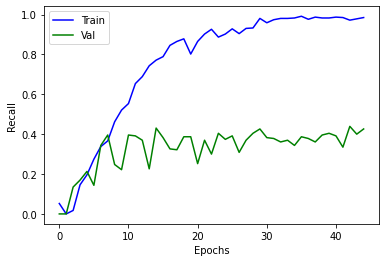

In [ ]:
plot_loss(history)
plot_auc(history)
plot_rec(history)


In [ ]:
y_pred = modello.predict(NR_ER_score_x)
y_pred = y_pred.round()
NR_ER_score_y_int = [int(i) for i in NR_ER_score_y]
print(classification_report(NR_ER_score_y_int,y_pred, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95       465
           1       0.60      0.12      0.20        50

    accuracy                           0.91       515
   macro avg       0.76      0.56      0.58       515
weighted avg       0.88      0.91      0.88       515



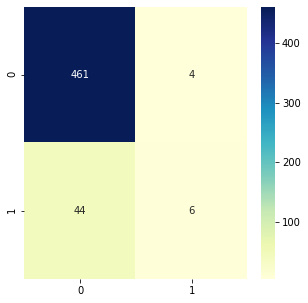

In [ ]:
cm = confusion_matrix(NR_ER_score_y_int,y_pred)
plt.subplots(figsize=(5,5))
sbn.heatmap(cm, annot=True,fmt='g',cmap="YlGnBu")

In [ ]:
history_score = modello.evaluate(NR_ER_score_x,NR_ER_score_y)
print("""Evaluation metrics:
\t{0}:\t{1}
\t{2}:\t{3}
\t{4}:\t{5}
\t{6}:\t{7}
\t{8}:\t{9}
\t{10}:\t{11}
\t{12}:\t{13}
\t{14}:\t{15}
\t{16}:\t{17}
""".format(modello.metrics_names[0],history_score[0],
           modello.metrics_names[1],history_score[1],
           modello.metrics_names[2],history_score[2],
           modello.metrics_names[3],history_score[3],
           modello.metrics_names[4],history_score[4],
           modello.metrics_names[5],history_score[5],
           modello.metrics_names[6],history_score[6],
           modello.metrics_names[7],history_score[7],
           modello.metrics_names[8],history_score[8]
          
          
))

515/515 [==============================] - 0s 217us/step
Evaluation metrics:
	loss:	0.286963559188021
	tp:	6.0
	fp:	4.0
	tn:	461.0
	fn:	44.0
	accuracy:	0.9067960977554321
	precision:	0.6000000238418579
	recall:	0.11999999731779099
	auc:	0.7255053520202637



<h3>Modello 2 </h3>

Rispetto alla rete precedente, viene valutato l'utilizzo del Dropout come primo layer. 

In [ ]:
#X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,stratify=Y, shuffle = True)

In [ ]:
kfold = StratifiedKFold(n_splits=3, shuffle=True)
#train scores
cvscores_train_loss = []
cvscores_train_auc = []
cvscores_train_rec = []
cvscores_train_prec = []

#validation scores
cvscores_val_loss = []
cvscores_val_auc = []
cvscores_val_rec = []
cvscores_val_prec = []

for train, test in kfold.split(X, Y):
    
    modello = Sequential()
    modello.add(Dropout(0.25))
    modello.add(Conv1D(100, kernel_size=(10), activation='relu', padding = 'same'))
    modello.add(keras.layers.GlobalMaxPooling1D())
    modello.add(Dense(64, activation = 'relu'))
    modello.add(Dropout(0,5))
    modello.add(Dense(1, activation='sigmoid'))

    early_stopping = EarlyStopping(
                                  monitor='val_loss', min_delta=0, patience=40, verbose=0, mode='auto',
                                  baseline=None, restore_best_weights=True)


    modello.compile(loss=keras.losses.BinaryCrossentropy(),optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=metrics())

    history = modello.fit(X[train], Y[train],
                        batch_size=256,
                        epochs=80,
                        verbose=1,
                        callbacks = [early_stopping],
                        validation_data = (X[test], Y[test])) 
    
    cvscores_train_loss.append(history.history['loss'][-1])
    cvscores_train_auc.append(history.history['auc'][-1])
    cvscores_train_rec.append(history.history['recall'][-1])   
    cvscores_train_prec.append(history.history['precision'][-1])

    cvscores_val_loss.append(history.history['val_loss'][-1])
    cvscores_val_auc.append(history.history['val_auc'][-1])
    cvscores_val_rec.append(history.history['val_recall'][-1])   
    cvscores_val_prec.append(history.history['val_precision'][-1])

print("Loss: ",np.mean(cvscores_val_loss),' +/- ' ,np.std(cvscores_val_loss))
print("AUC: ",np.mean(cvscores_val_auc),' +/- ',np.std(cvscores_val_auc))
print("Recall: ",np.mean(cvscores_val_rec),' +/- ',np.std(cvscores_val_rec))
print("Precision: ",np.mean(cvscores_val_prec),' +/- ',np.std(cvscores_val_prec))

    

Train on 4304 samples, validate on 2153 samples
Epoch 1/80
4304/4304 [==============================] - 2s 363us/step - loss: 0.3806 - tp: 13.0000 - fp: 96.0000 - tn: 3749.0000 - fn: 446.0000 - accuracy: 0.8741 - precision: 0.1193 - recall: 0.0283 - auc: 0.5141 - val_loss: 0.3392 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1923.0000 - val_fn: 230.0000 - val_accuracy: 0.8932 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6750
Epoch 2/80
4304/4304 [==============================] - 1s 275us/step - loss: 0.3200 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 3845.0000 - fn: 459.0000 - accuracy: 0.8934 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6749 - val_loss: 0.3106 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1923.0000 - val_fn: 230.0000 - val_accuracy: 0.8932 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7133
Epoch 3/80
4304/4304 [==============================] - 1s 274us/step - loss: 0.3071 - tp: 14.0000 - fp: 3.0000 - tn: 3842

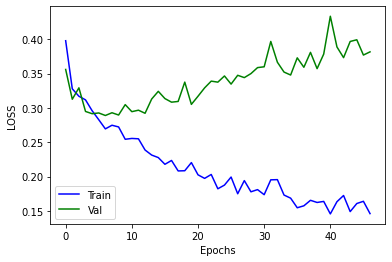

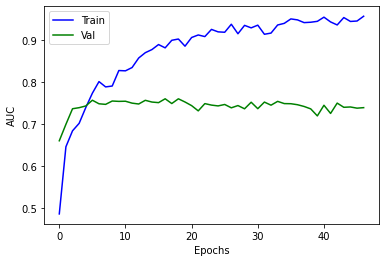

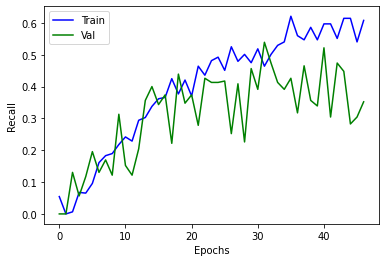

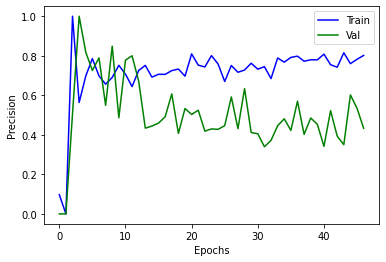

In [ ]:
plot_loss(history)
plot_auc(history)
plot_rec(history)
plot_prec(history)


In [ ]:
y_pred = modello.predict(NR_ER_score_x)
y_pred = y_pred.round()
NR_ER_score_y_int = [int(i) for i in NR_ER_score_y]
print(classification_report(NR_ER_score_y_int,y_pred, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95       465
           1       0.75      0.06      0.11        50

    accuracy                           0.91       515
   macro avg       0.83      0.53      0.53       515
weighted avg       0.89      0.91      0.87       515



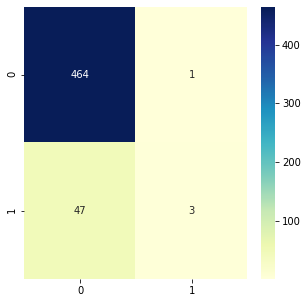

In [ ]:
cm = confusion_matrix(NR_ER_score_y_int,y_pred)
plt.subplots(figsize=(5,5))
sbn.heatmap(cm, annot=True,fmt='g',cmap="YlGnBu")

In [ ]:
history_score = modello.evaluate(NR_ER_score_x,NR_ER_score_y)
print("""Evaluation metrics:
\t{0}:\t{1}
\t{2}:\t{3}
\t{4}:\t{5}
\t{6}:\t{7}
\t{8}:\t{9}
\t{10}:\t{11}
\t{12}:\t{13}
\t{14}:\t{15}
\t{16}:\t{17}
""".format(modello.metrics_names[0],history_score[0],
           modello.metrics_names[1],history_score[1],
           modello.metrics_names[2],history_score[2],
           modello.metrics_names[3],history_score[3],
           modello.metrics_names[4],history_score[4],
           modello.metrics_names[5],history_score[5],
           modello.metrics_names[6],history_score[6],
           modello.metrics_names[7],history_score[7],
           modello.metrics_names[8],history_score[8]
          
          
))

515/515 [==============================] - 0s 268us/step
Evaluation metrics:
	loss:	0.30802778008855086
	tp:	3.0
	fp:	1.0
	tn:	464.0
	fn:	47.0
	accuracy:	0.9067960977554321
	precision:	0.75
	recall:	0.05999999865889549
	auc:	0.6420430541038513



<h3>Modello 3</h3>

In questo caso, viene testato l'effetto di un maggior numero di convoluzioni, con l'aggiunta di un Global Average Pooling prima del layer fully connected.

In [ ]:
kfold = StratifiedKFold(n_splits=3, shuffle=True)
#train scores
cvscores_train_loss = []
cvscores_train_auc = []
cvscores_train_rec = []
cvscores_train_prec = []

#validation scores
cvscores_val_loss = []
cvscores_val_auc = []
cvscores_val_rec = []
cvscores_val_prec = []

for train, test in kfold.split(X, Y):  
    
    
    modello = Sequential()
    modello.add(Conv1D(100, kernel_size=(10), activation='relu', padding = 'same'))
    modello.add(keras.layers.MaxPooling1D(pool_size=5, strides=None, padding="same"))
    modello.add(Conv1D(100, kernel_size=(10), activation = 'relu', padding = 'same'))
    modello.add(keras.layers.MaxPooling1D(pool_size=5, strides=None, padding="same"))
    modello.add(GlobalAveragePooling1D())
    modello.add(Dense(64, activation='relu'))
    modello.add(Dropout(0,5))
    modello.add(Dense(1, activation='sigmoid'))

    early_stopping = EarlyStopping(
                                  monitor='val_loss', min_delta=0, patience=40, verbose=0, mode='auto',
                                  baseline=None, restore_best_weights=True)


    modello.compile(loss=keras.losses.BinaryCrossentropy(),optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=metrics())

    history = modello.fit(X[train], Y[train],
                        batch_size=256,
                        epochs=80,
                        verbose=1,
                        callbacks = [early_stopping],
                        validation_data = (X[test], Y[test]))
    
    cvscores_train_loss.append(history.history['loss'][-1])
    cvscores_train_auc.append(history.history['auc'][-1])
    cvscores_train_rec.append(history.history['recall'][-1])   
    cvscores_train_prec.append(history.history['precision'][-1])

    cvscores_val_loss.append(history.history['val_loss'][-1])
    cvscores_val_auc.append(history.history['val_auc'][-1])
    cvscores_val_rec.append(history.history['val_recall'][-1])   
    cvscores_val_prec.append(history.history['val_precision'][-1])

print("Loss: ",np.mean(cvscores_val_loss),' +/- ' ,np.std(cvscores_val_loss))
print("AUC: ",np.mean(cvscores_val_auc),' +/- ',np.std(cvscores_val_auc))
print("Recall: ",np.mean(cvscores_val_rec),' +/- ',np.std(cvscores_val_rec))
print("Precision: ",np.mean(cvscores_val_prec),' +/- ',np.std(cvscores_val_prec))

    

Train on 4304 samples, validate on 2153 samples
Epoch 1/80
4304/4304 [==============================] - 3s 636us/step - loss: 0.4136 - tp: 28.0000 - fp: 228.0000 - tn: 3617.0000 - fn: 431.0000 - accuracy: 0.8469 - precision: 0.1094 - recall: 0.0610 - auc: 0.4816 - val_loss: 0.3361 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1923.0000 - val_fn: 230.0000 - val_accuracy: 0.8932 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6842
Epoch 2/80
4304/4304 [==============================] - 1s 301us/step - loss: 0.3350 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 3845.0000 - fn: 459.0000 - accuracy: 0.8934 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5951 - val_loss: 0.3337 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1923.0000 - val_fn: 230.0000 - val_accuracy: 0.8932 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6899
Epoch 3/80
4304/4304 [==============================] - 1s 293us/step - loss: 0.3286 - tp: 0.0000e+00 - fp: 0.0000e+00 - 

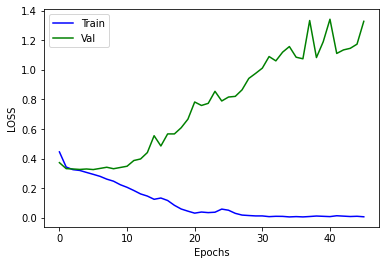

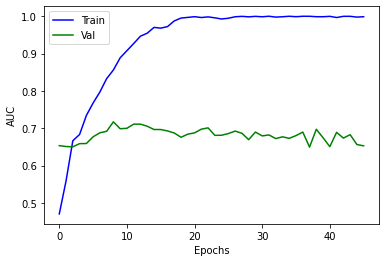

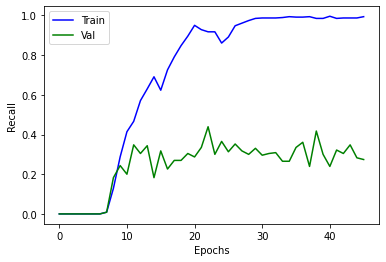

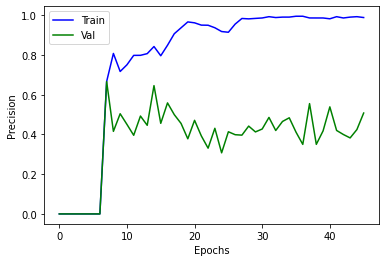

In [ ]:
plot_loss(history)
plot_auc(history)
plot_rec(history)
plot_prec(history)


In [ ]:
y_pred = modello.predict(NR_ER_score_x)
y_pred = y_pred.round()
NR_ER_score_y_int = [int(i) for i in NR_ER_score_y]
print(classification_report(NR_ER_score_y_int,y_pred, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95       465
           1       0.00      0.00      0.00        50

    accuracy                           0.90       515
   macro avg       0.45      0.50      0.47       515
weighted avg       0.82      0.90      0.86       515



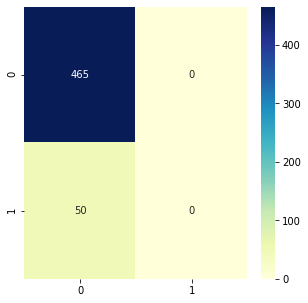

In [ ]:
cm = confusion_matrix(NR_ER_score_y_int,y_pred)
plt.subplots(figsize=(5,5))
sbn.heatmap(cm, annot=True,fmt='g',cmap="YlGnBu")

In [ ]:
history_score = modello.evaluate(NR_ER_score_x,NR_ER_score_y)
print("""Evaluation metrics:
\t{0}:\t{1}
\t{2}:\t{3}
\t{4}:\t{5}
\t{6}:\t{7}
\t{8}:\t{9}
\t{10}:\t{11}
\t{12}:\t{13}
\t{14}:\t{15}
\t{16}:\t{17}
""".format(modello.metrics_names[0],history_score[0],
           modello.metrics_names[1],history_score[1],
           modello.metrics_names[2],history_score[2],
           modello.metrics_names[3],history_score[3],
           modello.metrics_names[4],history_score[4],
           modello.metrics_names[5],history_score[5],
           modello.metrics_names[6],history_score[6],
           modello.metrics_names[7],history_score[7],
           modello.metrics_names[8],history_score[8]
          
          
))

515/515 [==============================] - 0s 260us/step
Evaluation metrics:
	loss:	0.31722762007447125
	tp:	0.0
	fp:	0.0
	tn:	465.0
	fn:	50.0
	accuracy:	0.9029126167297363
	precision:	0.0
	recall:	0.0
	auc:	0.6375698447227478



<h3>Modello 4</h3>

Viene riproposta la rete con una sola convoluzione, Dropout iniziale ed un lavyer di Global Averege Pooling come connessione con il layer fully connected. 

In [ ]:
kfold = StratifiedKFold(n_splits=3, shuffle=True)
#train scores
cvscores_train_loss = []
cvscores_train_auc = []
cvscores_train_rec = []
cvscores_train_prec = []

#validation scores
cvscores_val_loss = []
cvscores_val_auc = []
cvscores_val_rec = []
cvscores_val_prec = []

for train, test in kfold.split(X, Y):   
    
    modello = Sequential()
    modello.add(Dropout(0.25))
    modello.add(Conv1D(100, kernel_size=(10), activation='relu', padding = 'same'))
    modello.add(GlobalAveragePooling1D())
    modello.add(Dense(64, activation='relu'))
    modello.add(Dropout(0,5))
    modello.add(Dense(1, activation='sigmoid'))

    early_stopping = EarlyStopping(
                                  monitor='val_loss', min_delta=0, patience=40, verbose=0, mode='auto',
                                  baseline=None, restore_best_weights=True)


    modello.compile(loss=keras.losses.BinaryCrossentropy(),optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=metrics())

    history = modello.fit(X[train], Y[train],
                        batch_size=256,
                        epochs=80,
                        verbose=1,
                        callbacks = [early_stopping],
                        validation_data = (X[test], Y[test]))
    
    cvscores_train_loss.append(history.history['loss'][-1])
    cvscores_train_auc.append(history.history['auc'][-1])
    cvscores_train_rec.append(history.history['recall'][-1])   
    cvscores_train_prec.append(history.history['precision'][-1])

    cvscores_val_loss.append(history.history['val_loss'][-1])
    cvscores_val_auc.append(history.history['val_auc'][-1])
    cvscores_val_rec.append(history.history['val_recall'][-1])   
    cvscores_val_prec.append(history.history['val_precision'][-1])

print("Loss: ",np.mean(cvscores_val_loss),' +/- ' ,np.std(cvscores_val_loss))
print("AUC: ",np.mean(cvscores_val_auc),' +/- ',np.std(cvscores_val_auc))
print("Recall: ",np.mean(cvscores_val_rec),' +/- ',np.std(cvscores_val_rec))
print("Precision: ",np.mean(cvscores_val_prec),' +/- ',np.std(cvscores_val_prec))

    

Train on 4304 samples, validate on 2153 samples
Epoch 1/80
4304/4304 [==============================] - 2s 370us/step - loss: 0.4400 - tp: 23.0000 - fp: 217.0000 - tn: 3628.0000 - fn: 436.0000 - accuracy: 0.8483 - precision: 0.0958 - recall: 0.0501 - auc: 0.4694 - val_loss: 0.3853 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1923.0000 - val_fn: 230.0000 - val_accuracy: 0.8932 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4094
Epoch 2/80
4304/4304 [==============================] - 1s 280us/step - loss: 0.3581 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 3845.0000 - fn: 459.0000 - accuracy: 0.8934 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4892 - val_loss: 0.3377 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1923.0000 - val_fn: 230.0000 - val_accuracy: 0.8932 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6698
Epoch 3/80
4304/4304 [==============================] - 1s 285us/step - loss: 0.3365 - tp: 0.0000e+00 - fp: 0.0000e+00 - 

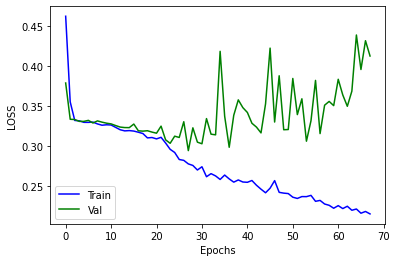

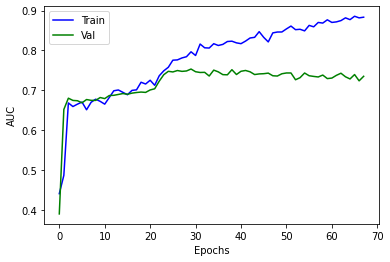

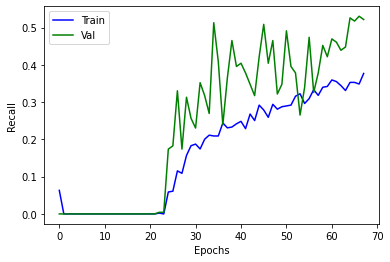

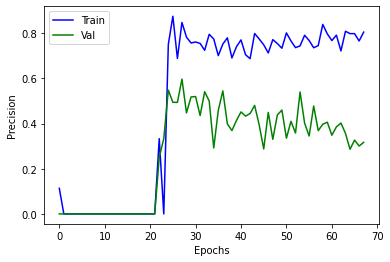

In [ ]:
plot_loss(history)
plot_auc(history)
plot_rec(history)
plot_prec(history)


In [ ]:
y_pred = modello.predict(NR_ER_score_x)
y_pred = y_pred.round()
NR_ER_score_y_int = [int(i) for i in NR_ER_score_y]
print(classification_report(NR_ER_score_y_int,y_pred, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95       465
           1       0.70      0.14      0.23        50

    accuracy                           0.91       515
   macro avg       0.81      0.57      0.59       515
weighted avg       0.89      0.91      0.88       515



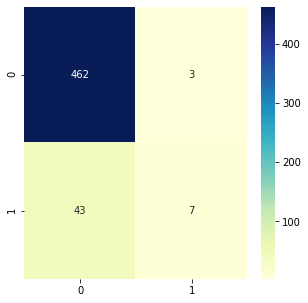

In [ ]:
cm = confusion_matrix(NR_ER_score_y_int,y_pred)
plt.subplots(figsize=(5,5))
sbn.heatmap(cm, annot=True,fmt='g',cmap="YlGnBu")

In [ ]:
history_score = modello.evaluate(NR_ER_score_x,NR_ER_score_y)
print("""Evaluation metrics:
\t{0}:\t{1}
\t{2}:\t{3}
\t{4}:\t{5}
\t{6}:\t{7}
\t{8}:\t{9}
\t{10}:\t{11}
\t{12}:\t{13}
\t{14}:\t{15}
\t{16}:\t{17}
""".format(modello.metrics_names[0],history_score[0],
           modello.metrics_names[1],history_score[1],
           modello.metrics_names[2],history_score[2],
           modello.metrics_names[3],history_score[3],
           modello.metrics_names[4],history_score[4],
           modello.metrics_names[5],history_score[5],
           modello.metrics_names[6],history_score[6],
           modello.metrics_names[7],history_score[7],
           modello.metrics_names[8],history_score[8]
          
          
))

515/515 [==============================] - 0s 258us/step
Evaluation metrics:
	loss:	0.2957577855335277
	tp:	7.0
	fp:	3.0
	tn:	462.0
	fn:	43.0
	accuracy:	0.9106796383857727
	precision:	0.699999988079071
	recall:	0.14000000059604645
	auc:	0.7026666402816772



<h3>Modello 5</h3>

Di seguito, viene testato l'effetto del Dropout come primo layer sulla rete con due convoluzioni. 

In [ ]:
kfold = StratifiedKFold(n_splits=3, shuffle=True)
#train scores
cvscores_train_loss = []
cvscores_train_auc = []
cvscores_train_rec = []
cvscores_train_prec = []

#validation scores
cvscores_val_loss = []
cvscores_val_auc = []
cvscores_val_rec = []
cvscores_val_prec = []

for train, test in kfold.split(X, Y):    
    
    modello = Sequential()
    modello.add(Dropout(0.25))
    modello.add(Conv1D(100, kernel_size=(10), activation='relu', padding = 'same'))
    modello.add(keras.layers.AveragePooling1D(pool_size=5, strides=None, padding="same"))
    modello.add(Conv1D(100, kernel_size=(10), activation = 'relu', padding = 'same'))
    modello.add(keras.layers.AveragePooling1D(pool_size=5, strides=None, padding="same"))
    modello.add(GlobalAveragePooling1D())
    modello.add(Dense(64, activation='relu'))
    modello.add(Dropout(0,5))
    modello.add(Dense(1, activation='sigmoid'))

    early_stopping = EarlyStopping(
                                  monitor='val_loss', min_delta=0, patience=40, verbose=0, mode='auto',
                                  baseline=None, restore_best_weights=True)


    modello.compile(loss=keras.losses.BinaryCrossentropy(),optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=metrics())

    history = modello.fit(X[train], Y[train],
                        batch_size=256,
                        epochs=80,
                        verbose=1,
                        callbacks = [early_stopping],
                        validation_data = (X[test], Y[test])) 
    cvscores_train_loss.append(history.history['loss'][-1])
    cvscores_train_auc.append(history.history['auc'][-1])
    cvscores_train_rec.append(history.history['recall'][-1])   
    cvscores_train_prec.append(history.history['precision'][-1])

    cvscores_val_loss.append(history.history['val_loss'][-1])
    cvscores_val_auc.append(history.history['val_auc'][-1])
    cvscores_val_rec.append(history.history['val_recall'][-1])   
    cvscores_val_prec.append(history.history['val_precision'][-1])

print("Loss: ",np.mean(cvscores_val_loss),' +/- ' ,np.std(cvscores_val_loss))
print("AUC: ",np.mean(cvscores_val_auc),' +/- ',np.std(cvscores_val_auc))
print("Recall: ",np.mean(cvscores_val_rec),' +/- ',np.std(cvscores_val_rec))
print("Precision: ",np.mean(cvscores_val_prec),' +/- ',np.std(cvscores_val_prec))

    

Train on 4304 samples, validate on 2153 samples
Epoch 1/80
4304/4304 [==============================] - 3s 611us/step - loss: 0.4205 - tp: 1.0000 - fp: 5.0000 - tn: 3840.0000 - fn: 458.0000 - accuracy: 0.8924 - precision: 0.1667 - recall: 0.0022 - auc: 0.4920 - val_loss: 0.3400 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1923.0000 - val_fn: 230.0000 - val_accuracy: 0.8932 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6775
Epoch 2/80
4304/4304 [==============================] - 1s 264us/step - loss: 0.3417 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 3845.0000 - fn: 459.0000 - accuracy: 0.8934 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5620 - val_loss: 0.3360 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1923.0000 - val_fn: 230.0000 - val_accuracy: 0.8932 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6734
Epoch 3/80
4304/4304 [==============================] - 1s 267us/step - loss: 0.3332 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn:

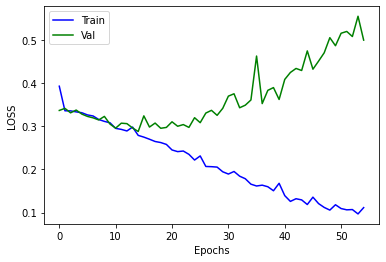

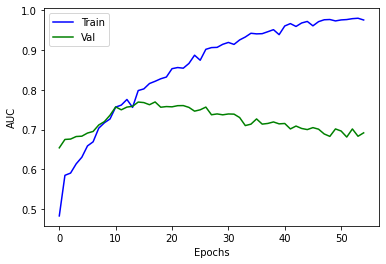

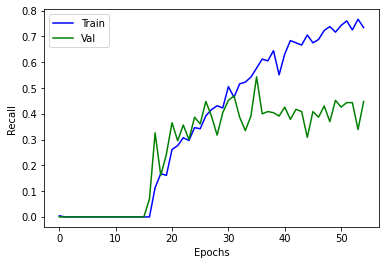

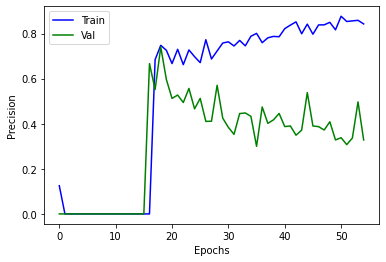

In [ ]:
plot_loss(history)
plot_auc(history)
plot_rec(history)
plot_prec(history)


In [ ]:
y_pred = modello.predict(NR_ER_score_x)
y_pred = y_pred.round()
NR_ER_score_y_int = [int(i) for i in NR_ER_score_y]
print(classification_report(NR_ER_score_y_int,y_pred, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95       465
           1       0.00      0.00      0.00        50

    accuracy                           0.90       515
   macro avg       0.45      0.50      0.47       515
weighted avg       0.82      0.90      0.86       515



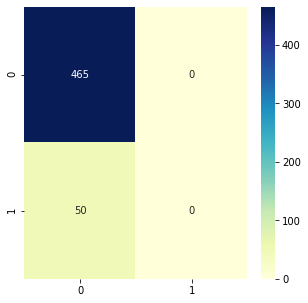

In [ ]:
cm = confusion_matrix(NR_ER_score_y_int,y_pred)
plt.subplots(figsize=(5,5))
sbn.heatmap(cm, annot=True,fmt='g',cmap="YlGnBu")

In [ ]:
history_score = modello.evaluate(NR_ER_score_x,NR_ER_score_y)
print("""Evaluation metrics:
\t{0}:\t{1}
\t{2}:\t{3}
\t{4}:\t{5}
\t{6}:\t{7}
\t{8}:\t{9}
\t{10}:\t{11}
\t{12}:\t{13}
\t{14}:\t{15}
\t{16}:\t{17}
""".format(modello.metrics_names[0],history_score[0],
           modello.metrics_names[1],history_score[1],
           modello.metrics_names[2],history_score[2],
           modello.metrics_names[3],history_score[3],
           modello.metrics_names[4],history_score[4],
           modello.metrics_names[5],history_score[5],
           modello.metrics_names[6],history_score[6],
           modello.metrics_names[7],history_score[7],
           modello.metrics_names[8],history_score[8]
          
          
))

515/515 [==============================] - 0s 261us/step
Evaluation metrics:
	loss:	0.28959930976762355
	tp:	0.0
	fp:	0.0
	tn:	465.0
	fn:	50.0
	accuracy:	0.9029126167297363
	precision:	0.0
	recall:	0.0
	auc:	0.7315269112586975



<h3>Modello 6 </h3>

Alla rete con una sola convoluzione, viene aggiunto un fattore di regolarizzazione del kernel.

In [ ]:
kfold = StratifiedKFold(n_splits=3, shuffle=True)
#train scores
cvscores_train_loss = []
cvscores_train_auc = []
cvscores_train_rec = []
cvscores_train_prec = []

#validation scores
cvscores_val_loss = []
cvscores_val_auc = []
cvscores_val_rec = []
cvscores_val_prec = []

for train, test in kfold.split(X, Y):    
    
    modello = Sequential()
    modello.add(Dropout(0.25))
    modello.add(Conv1D(100, kernel_size=(10), activation='relu', padding = 'same', kernel_regularizer = keras.regularizers.l2(1e-4)))
    modello.add(keras.layers.AveragePooling1D(pool_size=5, strides=None, padding="same"))
    modello.add(keras.layers.GlobalMaxPooling1D())
    modello.add(Dense(64, activation='relu'))
    modello.add(Dropout(0,5))
    modello.add(Dense(1, activation='sigmoid'))

    early_stopping = EarlyStopping(
                                  monitor='val_loss', min_delta=0, patience=40, verbose=0, mode='auto',
                                  baseline=None, restore_best_weights=True)


    modello.compile(loss=keras.losses.BinaryCrossentropy(),optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=metrics())

    history = modello.fit(X[train], Y[train],
                        batch_size=256,
                        epochs=80,
                        verbose=1,
                        callbacks = [early_stopping],
                        validation_data = (X[test], Y[test])) 
    
    cvscores_train_loss.append(history.history['loss'][-1])
    cvscores_train_auc.append(history.history['auc'][-1])
    cvscores_train_rec.append(history.history['recall'][-1])   
    cvscores_train_prec.append(history.history['precision'][-1])

    cvscores_val_loss.append(history.history['val_loss'][-1])
    cvscores_val_auc.append(history.history['val_auc'][-1])
    cvscores_val_rec.append(history.history['val_recall'][-1])   
    cvscores_val_prec.append(history.history['val_precision'][-1])

print("Loss: ",np.mean(cvscores_val_loss),' +/- ' ,np.std(cvscores_val_loss))
print("AUC: ",np.mean(cvscores_val_auc),' +/- ',np.std(cvscores_val_auc))
print("Recall: ",np.mean(cvscores_val_rec),' +/- ',np.std(cvscores_val_rec))
print("Precision: ",np.mean(cvscores_val_prec),' +/- ',np.std(cvscores_val_prec))

    

Train on 4304 samples, validate on 2153 samples
Epoch 1/80
4304/4304 [==============================] - 2s 357us/step - loss: 0.3717 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 3845.0000 - fn: 459.0000 - accuracy: 0.8934 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5365 - val_loss: 0.3400 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1923.0000 - val_fn: 230.0000 - val_accuracy: 0.8932 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6295
Epoch 2/80
4304/4304 [==============================] - 1s 280us/step - loss: 0.3329 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 3845.0000 - fn: 459.0000 - accuracy: 0.8934 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6575 - val_loss: 0.3338 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1923.0000 - val_fn: 230.0000 - val_accuracy: 0.8932 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6680
Epoch 3/80
4304/4304 [==============================] - 1s 282us/step - loss: 0.3212 - tp: 0.0000e+00 - fp: 

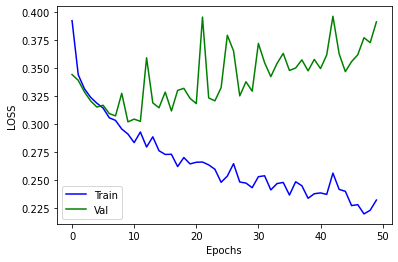

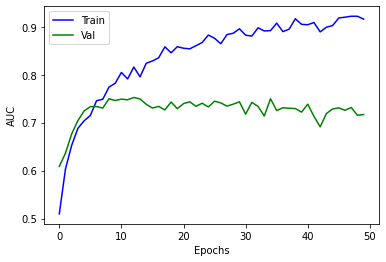

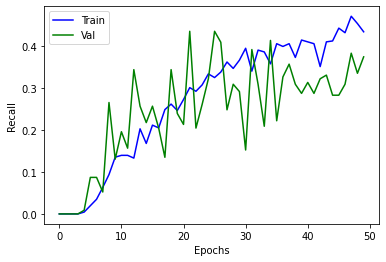

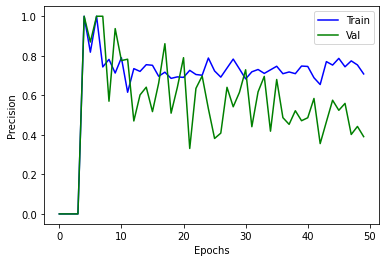

In [ ]:
plot_loss(history)
plot_auc(history)
plot_rec(history)
plot_prec(history)

In [ ]:
y_pred = modello.predict(NR_ER_score_x)
y_pred = y_pred.round()
NR_ER_score_y_int = [int(i) for i in NR_ER_score_y]
print(classification_report(NR_ER_score_y_int,y_pred, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95       465
           1       1.00      0.02      0.04        50

    accuracy                           0.90       515
   macro avg       0.95      0.51      0.49       515
weighted avg       0.91      0.90      0.86       515



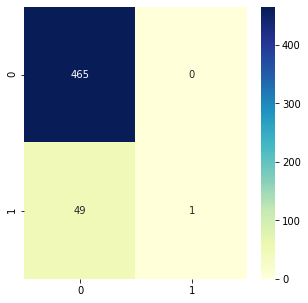

In [ ]:
cm = confusion_matrix(NR_ER_score_y_int,y_pred)
plt.subplots(figsize=(5,5))
sbn.heatmap(cm, annot=True,fmt='g',cmap="YlGnBu")

In [ ]:
history_score = modello.evaluate(NR_ER_score_x,NR_ER_score_y)
print("""Evaluation metrics:
\t{0}:\t{1}
\t{2}:\t{3}
\t{4}:\t{5}
\t{6}:\t{7}
\t{8}:\t{9}
\t{10}:\t{11}
\t{12}:\t{13}
\t{14}:\t{15}
\t{16}:\t{17}
""".format(modello.metrics_names[0],history_score[0],
           modello.metrics_names[1],history_score[1],
           modello.metrics_names[2],history_score[2],
           modello.metrics_names[3],history_score[3],
           modello.metrics_names[4],history_score[4],
           modello.metrics_names[5],history_score[5],
           modello.metrics_names[6],history_score[6],
           modello.metrics_names[7],history_score[7],
           modello.metrics_names[8],history_score[8]
          
          
))

515/515 [==============================] - 0s 279us/step
Evaluation metrics:
	loss:	0.31030756356646716
	tp:	1.0
	fp:	0.0
	tn:	465.0
	fn:	49.0
	accuracy:	0.9048543572425842
	precision:	1.0
	recall:	0.019999999552965164
	auc:	0.7089247703552246



Alla fine dei test, si nota che la rete nr 4 è la più performante.<br><br>
Di seguito, vengono introdotte tre tecniche utilizzate in caso di dataset sbilanciati: Random oversampling, SMOTE  Sui dataset coì creati, viene testato il modello migliore.

<h1>BALANCING THE DATASET</h1>

<h2>1) RANDOM OVERSAMPLING</h2>

In [ ]:
ros = RandomOverSampler(random_state=0)
X_reshape = X.reshape(-1,16800)
X_resampled, y_resampled = ros.fit_resample(X_reshape,Y)
X_resampled = X_resampled.reshape(-1,400,42)

In [ ]:
X_train = X_resampled 
y_train = y_resampled

In [ ]:
print('dataset originale: ', collections.Counter(Y))
print('dataset con random oversampling: ', collections.Counter(y_resampled))

dataset originale:  Counter({'0': 5768, '1': 689})
dataset con random oversampling:  Counter({'0': 5768, '1': 5768})


Dato che l'oversampling comporta la presenza degli stassi dati ripetuti, in questo caso la cross-validation non viene effettuata.

In [ ]:
modello = Sequential()
modello.add(Dropout(0.25))
modello.add(Conv1D(100, kernel_size=(10), activation='relu', padding = 'same'))
modello.add(GlobalAveragePooling1D())
modello.add(Dense(64, activation='relu'))
modello.add(Dropout(0,5))
modello.add(Dense(1, activation='sigmoid'))

early_stopping = EarlyStopping(
                              monitor='loss', min_delta=0, patience=40, verbose=0, mode='auto',
                              baseline=None, restore_best_weights=True)


modello.compile(loss=keras.losses.BinaryCrossentropy(),optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=metrics())

history = modello.fit(X_train, y_train,
                    batch_size=256,
                    epochs=80,
                    verbose=1,
                    callbacks = [early_stopping]) 
    


Epoch 1/80
11536/11536 [==============================] - 3s 244us/step - loss: 0.6574 - tp: 3900.0000 - fp: 2516.0000 - tn: 3252.0000 - fn: 1868.0000 - accuracy: 0.6200 - precision: 0.6079 - recall: 0.6761 - auc: 0.6620
Epoch 2/80
11536/11536 [==============================] - 3s 223us/step - loss: 0.6153 - tp: 3654.0000 - fp: 1741.0000 - tn: 4027.0000 - fn: 2114.0000 - accuracy: 0.6658 - precision: 0.6773 - recall: 0.6335 - auc: 0.7210
Epoch 3/80
11536/11536 [==============================] - 3s 218us/step - loss: 0.5853 - tp: 3648.0000 - fp: 1454.0000 - tn: 4314.0000 - fn: 2120.0000 - accuracy: 0.6902 - precision: 0.7150 - recall: 0.6325 - auc: 0.7531
Epoch 4/80
11536/11536 [==============================] - 3s 220us/step - loss: 0.5679 - tp: 3762.0000 - fp: 1365.0000 - tn: 4403.0000 - fn: 2006.0000 - accuracy: 0.7078 - precision: 0.7338 - recall: 0.6522 - auc: 0.7713
Epoch 5/80
11536/11536 [==============================] - 3s 218us/step - loss: 0.5543 - tp: 3740.0000 - fp: 1275.00

In [ ]:
y_pred = modello.predict(NR_ER_score_x)
y_pred = y_pred.round()
NR_ER_score_y_int = [int(i) for i in NR_ER_score_y]
print(classification_report(NR_ER_score_y_int,y_pred, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.93      0.94      0.94       465
           1       0.37      0.30      0.33        50

    accuracy                           0.88       515
   macro avg       0.65      0.62      0.63       515
weighted avg       0.87      0.88      0.88       515



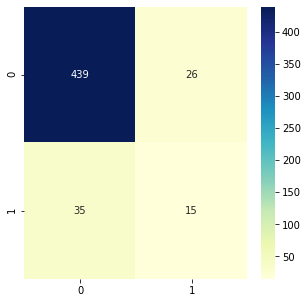

In [ ]:
cm = confusion_matrix(NR_ER_score_y_int,y_pred)
plt.subplots(figsize=(5,5))
sbn.heatmap(cm, annot=True,fmt='g',cmap="YlGnBu")

In [ ]:
history_score = modello.evaluate(NR_ER_score_x,NR_ER_score_y)
print("""Evaluation metrics:
\t{0}:\t{1}
\t{2}:\t{3}
\t{4}:\t{5}
\t{6}:\t{7}
\t{8}:\t{9}
\t{10}:\t{11}
\t{12}:\t{13}
\t{14}:\t{15}
\t{16}:\t{17}
""".format(modello.metrics_names[0],history_score[0],
           modello.metrics_names[1],history_score[1],
           modello.metrics_names[2],history_score[2],
           modello.metrics_names[3],history_score[3],
           modello.metrics_names[4],history_score[4],
           modello.metrics_names[5],history_score[5],
           modello.metrics_names[6],history_score[6],
           modello.metrics_names[7],history_score[7],
           modello.metrics_names[8],history_score[8]
          
          
))

515/515 [==============================] - 0s 483us/step
Evaluation metrics:
	loss:	0.6321563697483354
	tp:	15.0
	fp:	26.0
	tn:	439.0
	fn:	35.0
	accuracy:	0.8815534114837646
	precision:	0.3658536672592163
	recall:	0.30000001192092896
	auc:	0.6968817114830017



<h2>2) SMOTE </h2>

Poiché lo SMOTE genera dei dati sintetici ma non identici a quelli esistenti, in questo caso si è deciso di effettuare la cross-validation.

In [ ]:
X_reshape = X.reshape(-1,16800)
sm = SMOTENC(categorical_features=[0,41],random_state=0, sampling_strategy='minority',  k_neighbors=2)
X_res, y_res = sm.fit_resample(X_reshape, Y)
X_res = X_res.reshape(-1,400,42)

In [ ]:
print('dataset originale: ', collections.Counter(Y))
print('dataset con SMOTE: ', collections.Counter(y_res))

dataset originale:  Counter({'0': 5768, '1': 689})
dataset con SMOTE:  Counter({'0': 5768, '1': 5768})


In [ ]:
kfold = StratifiedKFold(n_splits=3, shuffle=True)
#train scores
cvscores_train_loss = []
cvscores_train_auc = []
cvscores_train_rec = []
cvscores_train_prec = []

#validation scores
cvscores_val_loss = []
cvscores_val_auc = []
cvscores_val_rec = []
cvscores_val_prec = []

for train, test in kfold.split(X_res, y_res):    
    
    modello = Sequential()
    modello.add(Dropout(0.25))
    modello.add(Conv1D(100, kernel_size=(10), activation='relu', padding = 'same'))
    modello.add(GlobalAveragePooling1D())
    modello.add(Dense(64, activation='relu'))
    modello.add(Dropout(0,5))
    modello.add(Dense(1, activation='sigmoid'))

    early_stopping = EarlyStopping(
                                  monitor='val_loss', min_delta=0, patience=40, verbose=0, mode='auto',
                                  baseline=None, restore_best_weights=True)


    modello.compile(loss=keras.losses.BinaryCrossentropy(),optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=metrics())
    
    history = modello.fit(X_res[train], y_res[train],
                        batch_size=256,
                        epochs=80,
                        verbose=1,
                        callbacks = [early_stopping],
                        validation_data = (X_res[test], y_res[test]))
    
    cvscores_train_loss.append(history.history['loss'][-1])
    cvscores_train_auc.append(history.history['auc'][-1])
    cvscores_train_rec.append(history.history['recall'][-1])   
    cvscores_train_prec.append(history.history['precision'][-1])

    cvscores_val_loss.append(history.history['val_loss'][-1])
    cvscores_val_auc.append(history.history['val_auc'][-1])
    cvscores_val_rec.append(history.history['val_recall'][-1])   
    cvscores_val_prec.append(history.history['val_precision'][-1])

print("Loss: ",np.mean(cvscores_val_loss),' +/- ' ,np.std(cvscores_val_loss))
print("AUC: ",np.mean(cvscores_val_auc),' +/- ',np.std(cvscores_val_auc))
print("Recall: ",np.mean(cvscores_val_rec),' +/- ',np.std(cvscores_val_rec))
print("Precision: ",np.mean(cvscores_val_prec),' +/- ',np.std(cvscores_val_prec))

    

Train on 7690 samples, validate on 3846 samples
Epoch 1/80
7690/7690 [==============================] - 3s 328us/step - loss: 0.6524 - tp: 2467.0000 - fp: 1578.0000 - tn: 2267.0000 - fn: 1378.0000 - accuracy: 0.6156 - precision: 0.6099 - recall: 0.6416 - auc: 0.6678 - val_loss: 0.6040 - val_tp: 1281.0000 - val_fp: 584.0000 - val_tn: 1339.0000 - val_fn: 642.0000 - val_accuracy: 0.6812 - val_precision: 0.6869 - val_recall: 0.6661 - val_auc: 0.7375
Epoch 2/80
7690/7690 [==============================] - 2s 261us/step - loss: 0.6089 - tp: 2372.0000 - fp: 1039.0000 - tn: 2806.0000 - fn: 1473.0000 - accuracy: 0.6733 - precision: 0.6954 - recall: 0.6169 - auc: 0.7325 - val_loss: 0.5703 - val_tp: 1217.0000 - val_fp: 403.0000 - val_tn: 1520.0000 - val_fn: 706.0000 - val_accuracy: 0.7116 - val_precision: 0.7512 - val_recall: 0.6329 - val_auc: 0.7758
Epoch 3/80
7690/7690 [==============================] - 2s 260us/step - loss: 0.5733 - tp: 2517.0000 - fp: 953.0000 - tn: 2892.0000 - fn: 1328.0000 

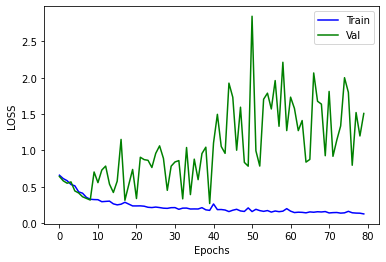

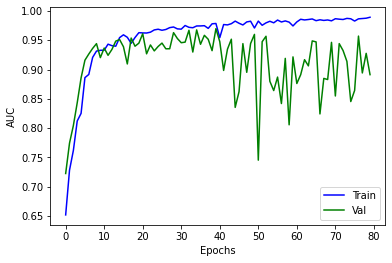

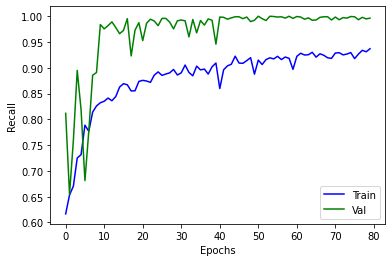

In [ ]:
plot_loss(history)
plot_auc(history)
plot_rec(history)


In [ ]:
y_pred = modello.predict(NR_ER_score_x)
y_pred = y_pred.round()
NR_ER_score_y_int = [int(i) for i in NR_ER_score_y]
print(classification_report(NR_ER_score_y_int,y_pred, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.95      0.82      0.88       465
           1       0.25      0.56      0.34        50

    accuracy                           0.79       515
   macro avg       0.60      0.69      0.61       515
weighted avg       0.88      0.79      0.82       515



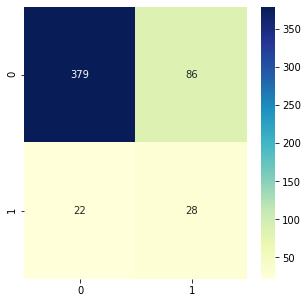

In [ ]:
cm = confusion_matrix(NR_ER_score_y_int,y_pred)
plt.subplots(figsize=(5,5))
sbn.heatmap(cm, annot=True,fmt='g',cmap="YlGnBu")

In [ ]:
history_score = modello.evaluate(NR_ER_score_x,NR_ER_score_y)
print("""Evaluation metrics:
\t{0}:\t{1}
\t{2}:\t{3}
\t{4}:\t{5}
\t{6}:\t{7}
\t{8}:\t{9}
\t{10}:\t{11}
\t{12}:\t{13}
\t{14}:\t{15}
\t{16}:\t{17}
""".format(modello.metrics_names[0],history_score[0],
           modello.metrics_names[1],history_score[1],
           modello.metrics_names[2],history_score[2],
           modello.metrics_names[3],history_score[3],
           modello.metrics_names[4],history_score[4],
           modello.metrics_names[5],history_score[5],
           modello.metrics_names[6],history_score[6],
           modello.metrics_names[7],history_score[7],
           modello.metrics_names[8],history_score[8]
          
          
))

515/515 [==============================] - 0s 248us/step
Evaluation metrics:
	loss:	0.5292790937192232
	tp:	28.0
	fp:	86.0
	tn:	379.0
	fn:	22.0
	accuracy:	0.7902912497520447
	precision:	0.24561403691768646
	recall:	0.5600000023841858
	auc:	0.7205591797828674



In [ ]:
history_score = modello.evaluate(NR_ER_score_x,NR_ER_score_y)
print(modello.metrics_names)
history_score

515/515 [==============================] - 0s 251us/step
['loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc']


[0.5292790937192232,
 28.0,
 86.0,
 379.0,
 22.0,
 0.7902912497520447,
 0.24561403691768646,
 0.5600000023841858,
 0.7205591797828674]

<h1>OTTIMIZZAZIONE</h1>

<h2>1) Funzione da ottimizzare: loss</h2>

In [ ]:
def create_model(filters,kernel,lr,neurons):
    
    modello = Sequential()
    modello.add(Dropout(0.25))
    modello.add(Conv1D(filters, kernel_size=(kernel), activation='relu', padding = 'same'))
    modello.add(GlobalAveragePooling1D())
    modello.add(Dense(neurons, activation='relu'))
    modello.add(Dropout(0,5))
    modello.add(Dense(1, activation='sigmoid'))

    modello.compile(loss=keras.losses.BinaryCrossentropy(),optimizer=keras.optimizers.Adam(learning_rate=lr), metrics=metrics())

    return(modello)

In [ ]:
def model_fit(filters,kernel,lr,neurons):

    X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,stratify=Y)
    model = create_model(filters,kernel,lr,neurons)

    early_stopping = EarlyStopping(
                              monitor='val_loss', min_delta=0, patience=20, verbose=0, mode='auto',
                              baseline=None, restore_best_weights=True)
    history = model.fit(X_train, y_train,
                      batch_size=256,
                      epochs=80,
                      verbose=1,
                      callbacks = [early_stopping],
                      validation_data=(X_test, y_test),
                      )
    
    evaluation = history.history['val_loss'][-1]

    print("Optimized Parameters:\n ")
    print( 'lr '+str(lr)+'\n')
    print( 'filters '+str(filters)+'\n')
    print( 'kernel '+str(kernel)+'\n')
    print( 'neurons '+str(neurons)+'\n')


    return(evaluation)

In [ ]:
def f(x):
    evaluation = model_fit(

      lr = float(x[:,0]),
      neurons = int(x[:,1]),
      filters = int(x[:,2]), 
      kernel = int(x[:,3])
       )
    score = evaluation
    print('Val_loss: ' + str(score))
    return(score)

In [ ]:
bounds = [
          {'name': 'lr', 'type': 'discrete', 'domain': (0.1,0.01,0.001,0.0001)},
          {'name': 'neurons', 'type': 'discrete', 'domain': (16,32,64,128,256,512)},
          {'name': 'filters', 'type': 'continuous', 'domain': (1,500)},
          {'name': 'kernel', 'type': 'continuous', 'domain': (1,51)},
          ]


In [ ]:
myBopt_hyp =GPyOpt.methods.BayesianOptimization(f=f,domain=bounds,initial_design_numdata = 10,model_type="GP_MCMC",acquisition_type='EI_MCMC')   

Train on 5165 samples, validate on 1292 samples
Epoch 1/80
5165/5165 [==============================] - 8s 1ms/step - loss: 0.6885 - tp: 74.0000 - fp: 576.0000 - tn: 4038.0000 - fn: 477.0000 - accuracy: 0.7961 - precision: 0.1138 - recall: 0.1343 - auc: 0.4703 - val_loss: 0.6813 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1154.0000 - val_fn: 138.0000 - val_accuracy: 0.8932 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3947
Epoch 2/80
5165/5165 [==============================] - 1s 143us/step - loss: 0.6737 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4614.0000 - fn: 551.0000 - accuracy: 0.8933 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4148 - val_loss: 0.6638 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1154.0000 - val_fn: 138.0000 - val_accuracy: 0.8932 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3764
Epoch 3/80
5165/5165 [==============================] - 1s 143us/step - loss: 0.6524 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn

reconstraining parameters GP_regression.rbf
reconstraining parameters GP_regression.Gaussian_noise.variance


Train on 5165 samples, validate on 1292 samples
Epoch 1/80
5165/5165 [==============================] - 1s 274us/step - loss: 0.9963 - tp: 0.0000e+00 - fp: 4.0000 - tn: 4610.0000 - fn: 551.0000 - accuracy: 0.8925 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4786 - val_loss: 0.3547 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1154.0000 - val_fn: 138.0000 - val_accuracy: 0.8932 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5138
Epoch 2/80
5165/5165 [==============================] - 1s 214us/step - loss: 0.3449 - tp: 3.0000 - fp: 25.0000 - tn: 4589.0000 - fn: 548.0000 - accuracy: 0.8891 - precision: 0.1071 - recall: 0.0054 - auc: 0.5533 - val_loss: 0.3403 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1154.0000 - val_fn: 138.0000 - val_accuracy: 0.8932 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6070
Epoch 3/80
5165/5165 [==============================] - 1s 207us/step - loss: 0.3391 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 46

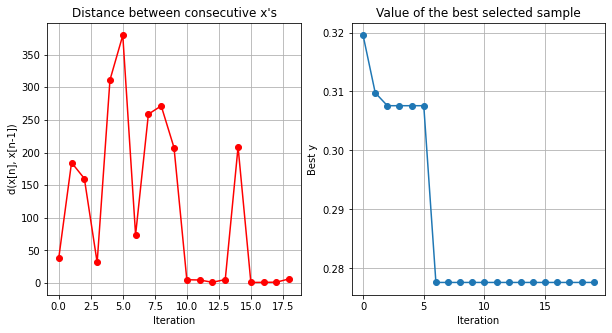

In [ ]:
myBopt_hyp.run_optimization(max_iter = 10)
x_best = myBopt_hyp.x_opt
print(x_best)
myBopt_hyp.plot_convergence()

In [ ]:
print("""
Optimized Parameters:
\t{0}:\t{1}
\t{2}:\t{3}
\t{3}:\t{4}
\t{5}:\t{6}

""".format(bounds[0]["name"],myBopt_hyp.x_opt[0],
           bounds[1]["name"],myBopt_hyp.x_opt[1],
           bounds[3]["name"],myBopt_hyp.x_opt[3],
           bounds[2]["name"],myBopt_hyp.x_opt[2],
))
print("optimized Val_loss: {0}".format(myBopt_hyp.fx_opt))


Optimized Parameters:
	lr:	0.1
	neurons:	64.0
	64.0:	kernel
	16.841806108443564:	filters


optimized Val_loss: 0.27760994155248253


In [ ]:
bounds

[{'domain': (0.1, 0.01, 0.001, 0.0001), 'name': 'lr', 'type': 'discrete'},
 {'domain': (16, 32, 64, 128, 256, 512),
  'name': 'neurons',
  'type': 'discrete'},
 {'domain': (1, 500), 'name': 'filters', 'type': 'continuous'},
 {'domain': (1, 51), 'name': 'kernel', 'type': 'continuous'}]

In [ ]:
myBopt_hyp.x_opt

array([1.00000000e-01, 6.40000000e+01, 3.86640484e+02, 1.68418061e+01])

<h4>Alleniamo il modello ottimizzato sul dataset originale:</h4>

In [ ]:
kfold = StratifiedKFold(n_splits=3, shuffle=True)
#train scores
cvscores_train_loss = []
cvscores_train_auc = []
cvscores_train_rec = []
cvscores_train_prec = []

#validation scores
cvscores_val_loss = []
cvscores_val_auc = []
cvscores_val_rec = []
cvscores_val_prec = []

for train, test in kfold.split(X,Y):    
    
    modello = Sequential()
    modello.add(Dropout(0.25))
    modello.add(Conv1D(387, kernel_size=(17), activation='relu', padding = 'same'))
    modello.add(GlobalAveragePooling1D())
    modello.add(Dense(64, activation='relu'))
    modello.add(Dropout(0,5))
    modello.add(Dense(1, activation='sigmoid'))

    early_stopping = EarlyStopping(
                                  monitor='val_loss', min_delta=0, patience=40, verbose=0, mode='auto',
                                  baseline=None, restore_best_weights=True)


    modello.compile(loss=keras.losses.BinaryCrossentropy(),optimizer=keras.optimizers.Adam(learning_rate=0.1), metrics=metrics())
    
    history = modello.fit(X[train], Y[train],
                        batch_size=256,
                        epochs=80,
                        verbose=1,
                        callbacks = [early_stopping],
                        validation_data = (X[test], Y[test]))
    
    cvscores_train_loss.append(history.history['loss'][-1])
    cvscores_train_auc.append(history.history['auc'][-1])
    cvscores_train_rec.append(history.history['recall'][-1])   
    cvscores_train_prec.append(history.history['precision'][-1])

    cvscores_val_loss.append(history.history['val_loss'][-1])
    cvscores_val_auc.append(history.history['val_auc'][-1])
    cvscores_val_rec.append(history.history['val_recall'][-1])   
    cvscores_val_prec.append(history.history['val_precision'][-1])

print("Loss: ",np.mean(cvscores_val_loss),' +/- ' ,np.std(cvscores_val_loss))
print("AUC: ",np.mean(cvscores_val_auc),' +/- ',np.std(cvscores_val_auc))
print("Recall: ",np.mean(cvscores_val_rec),' +/- ',np.std(cvscores_val_rec))
print("Precision: ",np.mean(cvscores_val_prec),' +/- ',np.std(cvscores_val_prec))

    

Train on 4304 samples, validate on 2153 samples
Epoch 1/80
4304/4304 [==============================] - 2s 350us/step - loss: 0.5524 - tp: 11.0000 - fp: 34.0000 - tn: 3811.0000 - fn: 448.0000 - accuracy: 0.8880 - precision: 0.2444 - recall: 0.0240 - auc: 0.5026 - val_loss: 0.3316 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1923.0000 - val_fn: 230.0000 - val_accuracy: 0.8932 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6859
Epoch 2/80
4304/4304 [==============================] - 1s 211us/step - loss: 0.3367 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 3845.0000 - fn: 459.0000 - accuracy: 0.8934 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5962 - val_loss: 0.3271 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1923.0000 - val_fn: 230.0000 - val_accuracy: 0.8932 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6903
Epoch 3/80
4304/4304 [==============================] - 1s 212us/step - loss: 0.3408 - tp: 0.0000e+00 - fp: 0.0000e+00 - t

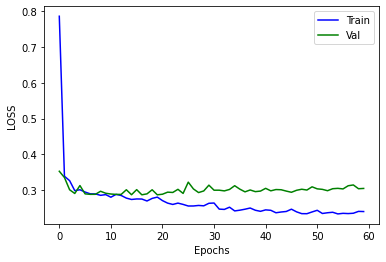

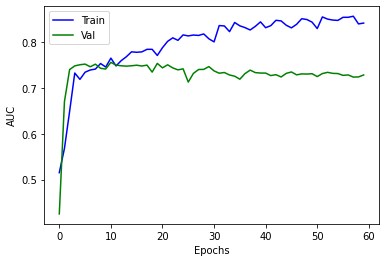

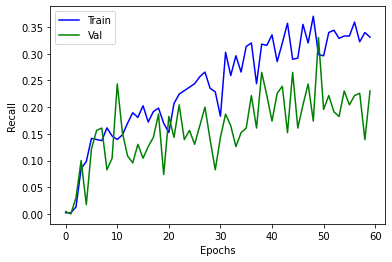

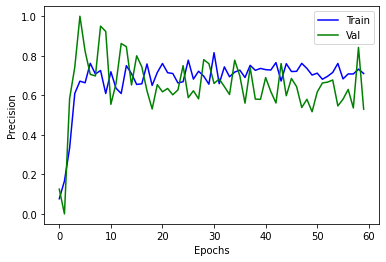

In [ ]:
plot_loss(history)
plot_auc(history)
plot_rec(history)
plot_prec(history)


In [ ]:
y_pred = modello.predict(NR_ER_score_x)
y_pred = y_pred.round()
NR_ER_score_y_int = [int(i) for i in NR_ER_score_y]
print(classification_report(NR_ER_score_y_int,y_pred, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95       465
           1       1.00      0.02      0.04        50

    accuracy                           0.90       515
   macro avg       0.95      0.51      0.49       515
weighted avg       0.91      0.90      0.86       515



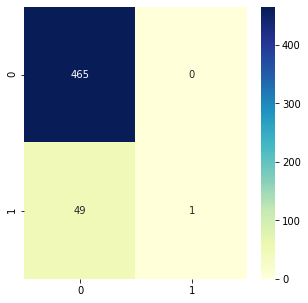

In [ ]:
cm = confusion_matrix(NR_ER_score_y_int,y_pred)
plt.subplots(figsize=(5,5))
sbn.heatmap(cm, annot=True,fmt='g',cmap="YlGnBu")

In [ ]:
history_score = modello.evaluate(NR_ER_score_x,NR_ER_score_y)
print("""Evaluation metrics:
\t{0}:\t{1}
\t{2}:\t{3}
\t{4}:\t{5}
\t{6}:\t{7}
\t{8}:\t{9}
\t{10}:\t{11}
\t{12}:\t{13}
\t{14}:\t{15}
\t{16}:\t{17}
""".format(modello.metrics_names[0],history_score[0],
           modello.metrics_names[1],history_score[1],
           modello.metrics_names[2],history_score[2],
           modello.metrics_names[3],history_score[3],
           modello.metrics_names[4],history_score[4],
           modello.metrics_names[5],history_score[5],
           modello.metrics_names[6],history_score[6],
           modello.metrics_names[7],history_score[7],
           modello.metrics_names[8],history_score[8]
          
          
))

515/515 [==============================] - 0s 191us/step
Evaluation metrics:
	loss:	0.2858133741012476
	tp:	1.0
	fp:	0.0
	tn:	465.0
	fn:	49.0
	accuracy:	0.9048543572425842
	precision:	1.0
	recall:	0.019999999552965164
	auc:	0.7305805683135986



<h4>Alleniamo il dataset originale sul dataset SMOTE:</h4>

In [ ]:
X_reshape = X.reshape(-1,16800)
sm = SMOTENC(categorical_features=[0, 41],random_state=0, sampling_strategy='minority',  k_neighbors=3)
X_res, y_res = sm.fit_resample(X_reshape, Y)
X_res = X_res.reshape(-1,400,42)

In [ ]:
kfold = StratifiedKFold(n_splits=3, shuffle=True)
#train scores
cvscores_train_loss = []
cvscores_train_auc = []
cvscores_train_rec = []
cvscores_train_prec = []

#validation scores
cvscores_val_loss = []
cvscores_val_auc = []
cvscores_val_rec = []
cvscores_val_prec = []

for train, test in kfold.split(X_res,y_res):    
    
    modello = Sequential()
    modello.add(Dropout(0.25))
    modello.add(Conv1D(387, kernel_size=(17), activation='relu', padding = 'same'))
    modello.add(GlobalAveragePooling1D())
    modello.add(Dense(64, activation='relu'))
    modello.add(Dropout(0,5))
    modello.add(Dense(1, activation='sigmoid'))

    early_stopping = EarlyStopping(
                                  monitor='val_loss', min_delta=0, patience=40, verbose=0, mode='auto',
                                  baseline=None, restore_best_weights=True)


    modello.compile(loss=keras.losses.BinaryCrossentropy(),optimizer=keras.optimizers.Adam(learning_rate=0.1), metrics=metrics())
    
    history = modello.fit(X_res[train], y_res[train],
                        batch_size=256,
                        epochs=80,
                        verbose=1,
                        callbacks = [early_stopping],
                        validation_data = (X_res[test], y_res[test]))
    
    cvscores_train_loss.append(history.history['loss'][-1])
    cvscores_train_auc.append(history.history['auc'][-1])
    cvscores_train_rec.append(history.history['recall'][-1])   
    cvscores_train_prec.append(history.history['precision'][-1])

    cvscores_val_loss.append(history.history['val_loss'][-1])
    cvscores_val_auc.append(history.history['val_auc'][-1])
    cvscores_val_rec.append(history.history['val_recall'][-1])   
    cvscores_val_prec.append(history.history['val_precision'][-1])

print("Loss: ",np.mean(cvscores_val_loss),' +/- ' ,np.std(cvscores_val_loss))
print("AUC: ",np.mean(cvscores_val_auc),' +/- ',np.std(cvscores_val_auc))
print("Recall: ",np.mean(cvscores_val_rec),' +/- ',np.std(cvscores_val_rec))
print("Precision: ",np.mean(cvscores_val_prec),' +/- ',np.std(cvscores_val_prec))

    

Train on 7690 samples, validate on 3846 samples
Epoch 1/80
7690/7690 [==============================] - 10s 1ms/step - loss: 1.2861 - tp: 2435.0000 - fp: 2274.0000 - tn: 1571.0000 - fn: 1410.0000 - accuracy: 0.5209 - precision: 0.5171 - recall: 0.6333 - auc: 0.5168 - val_loss: 0.6799 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1923.0000 - val_fn: 1923.0000 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7223
Epoch 2/80
7690/7690 [==============================] - 3s 455us/step - loss: 0.5476 - tp: 2669.0000 - fp: 955.0000 - tn: 2890.0000 - fn: 1176.0000 - accuracy: 0.7229 - precision: 0.7365 - recall: 0.6941 - auc: 0.7989 - val_loss: 0.6404 - val_tp: 1818.0000 - val_fp: 1124.0000 - val_tn: 799.0000 - val_fn: 105.0000 - val_accuracy: 0.6804 - val_precision: 0.6179 - val_recall: 0.9454 - val_auc: 0.8709
Epoch 3/80
7690/7690 [==============================] - 3s 455us/step - loss: 0.4508 - tp: 2943.0000 - fp: 726.0000 - tn: 3119.0000 - fn: 

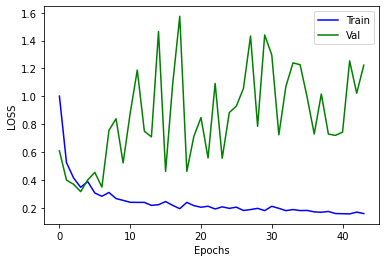

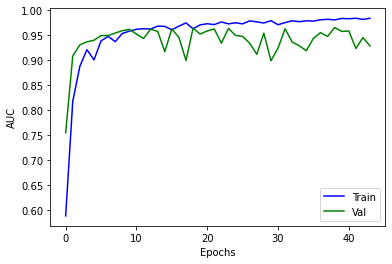

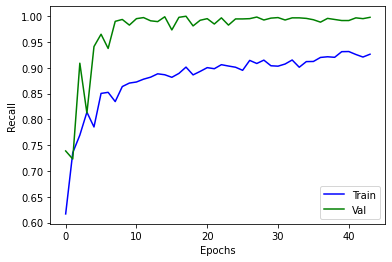

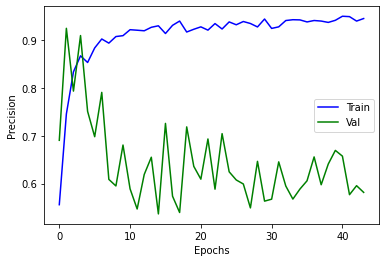

In [ ]:
plot_loss(history)
plot_auc(history)
plot_rec(history)
plot_prec(history)


In [ ]:
y_pred = modello.predict(NR_ER_score_x)
y_pred = y_pred.round()
NR_ER_score_y_int = [int(i) for i in NR_ER_score_y]
print(classification_report(NR_ER_score_y_int,y_pred, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93       465
           1       0.36      0.34      0.35        50

    accuracy                           0.88       515
   macro avg       0.65      0.64      0.64       515
weighted avg       0.87      0.88      0.88       515



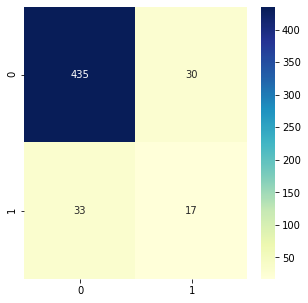

In [ ]:
cm = confusion_matrix(NR_ER_score_y_int,y_pred)
plt.subplots(figsize=(5,5))
sbn.heatmap(cm, annot=True,fmt='g',cmap="YlGnBu")

In [ ]:
history_score = modello.evaluate(NR_ER_score_x,NR_ER_score_y)
print("""Evaluation metrics:
\t{0}:\t{1}
\t{2}:\t{3}
\t{4}:\t{5}
\t{6}:\t{7}
\t{8}:\t{9}
\t{10}:\t{11}
\t{12}:\t{13}
\t{14}:\t{15}
\t{16}:\t{17}
""".format(modello.metrics_names[0],history_score[0],
           modello.metrics_names[1],history_score[1],
           modello.metrics_names[2],history_score[2],
           modello.metrics_names[3],history_score[3],
           modello.metrics_names[4],history_score[4],
           modello.metrics_names[5],history_score[5],
           modello.metrics_names[6],history_score[6],
           modello.metrics_names[7],history_score[7],
           modello.metrics_names[8],history_score[8]
          
          
))

515/515 [==============================] - 0s 311us/step
Evaluation metrics:
	loss:	0.34727330814721513
	tp:	17.0
	fp:	30.0
	tn:	435.0
	fn:	33.0
	accuracy:	0.8776699304580688
	precision:	0.3617021143436432
	recall:	0.3400000035762787
	auc:	0.654430091381073



<h2>2) Funzione da ottimizzare: F2Score</h2>

In [ ]:
def create_model(filters,kernel,lr,neurons):
    
    modello = Sequential()
    modello.add(Dropout(0.25))
    modello.add(Conv1D(filters, kernel_size=(kernel), activation='relu', padding = 'same'))
    modello.add(GlobalAveragePooling1D())
    modello.add(Dense(neurons, activation='relu'))
    modello.add(Dropout(0,5))
    modello.add(Dense(1, activation='sigmoid'))

    modello.compile(loss=keras.losses.BinaryCrossentropy(),optimizer=keras.optimizers.Adam(learning_rate=lr), metrics=metrics())

    return(modello)

In [ ]:
def model_fit(filters,kernel,lr,neurons):

    X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,stratify=Y)
    model = create_model(filters,kernel,lr,neurons)

    early_stopping = EarlyStopping(
                              monitor='val_loss', min_delta=0, patience=20, verbose=0, mode='auto',
                              baseline=None, restore_best_weights=True)
    history = model.fit(X_train, y_train,
                      batch_size=256,
                      epochs=80,
                      verbose=1,
                      callbacks = [early_stopping],
                      validation_data=(X_test, y_test),
                      )
    try:
        evaluation = (5*history.history['val_precision'][-1]*history.history['val_recall'][-1])/((4*history.history['val_precision'][-1])+history.history['val_recall'][-1])
    except:
        evaluation = 0

    print("Optimized Parameters:\n ")
    print( 'lr '+str(lr)+'\n')
    print( 'filters '+str(filters)+'\n')
    print( 'kernel '+str(kernel)+'\n')
    print( 'neurons '+str(neurons)+'\n')


    return(evaluation)

In [ ]:
def f(x):
    evaluation = model_fit(

      lr = float(x[:,0]),
      neurons = int(x[:,1]),
      filters = int(x[:,2]), 
      kernel = int(x[:,3])
       )
    score = evaluation
    print('Val_F2Score: ' + str(score))
    return(-score)

In [ ]:
bounds = [
          {'name': 'lr', 'type': 'discrete', 'domain': (0.1,0.01,0.001,0.0001)},
          {'name': 'neurons', 'type': 'discrete', 'domain': (16,32,64,128,256,512)},
          {'name': 'filters', 'type': 'continuous', 'domain': (1,500)},
          {'name': 'kernel', 'type': 'continuous', 'domain': (1,51)},
          ]


In [ ]:
myBopt_hyp =GPyOpt.methods.BayesianOptimization(f=f,domain=bounds,initial_design_numdata = 10,model_type="GP_MCMC",acquisition_type='EI_MCMC')   

Train on 5165 samples, validate on 1292 samples
Epoch 1/80
5165/5165 [==============================] - 1s 287us/step - loss: 0.4026 - tp: 27.0000 - fp: 229.0000 - tn: 4385.0000 - fn: 524.0000 - accuracy: 0.8542 - precision: 0.1055 - recall: 0.0490 - auc: 0.4708 - val_loss: 0.3310 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1154.0000 - val_fn: 138.0000 - val_accuracy: 0.8932 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6643
Epoch 2/80
5165/5165 [==============================] - 1s 193us/step - loss: 0.3265 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4614.0000 - fn: 551.0000 - accuracy: 0.8933 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6793 - val_loss: 0.3246 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1154.0000 - val_fn: 138.0000 - val_accuracy: 0.8932 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6784
Epoch 3/80
5165/5165 [==============================] - 1s 195us/step - loss: 0.3168 - tp: 0.0000e+00 - fp: 0.0000e+00 - 

reconstraining parameters GP_regression.rbf
reconstraining parameters GP_regression.Gaussian_noise.variance


Train on 5165 samples, validate on 1292 samples
Epoch 1/80
5165/5165 [==============================] - 1s 243us/step - loss: 0.5160 - tp: 29.0000 - fp: 227.0000 - tn: 4387.0000 - fn: 522.0000 - accuracy: 0.8550 - precision: 0.1133 - recall: 0.0526 - auc: 0.4590 - val_loss: 0.4366 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1154.0000 - val_fn: 138.0000 - val_accuracy: 0.8932 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3617
Epoch 2/80
5165/5165 [==============================] - 1s 182us/step - loss: 0.4034 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4614.0000 - fn: 551.0000 - accuracy: 0.8933 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.3860 - val_loss: 0.3609 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1154.0000 - val_fn: 138.0000 - val_accuracy: 0.8932 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4609
Epoch 3/80
5165/5165 [==============================] - 1s 182us/step - loss: 0.3456 - tp: 0.0000e+00 - fp: 0.0000e+00 - 

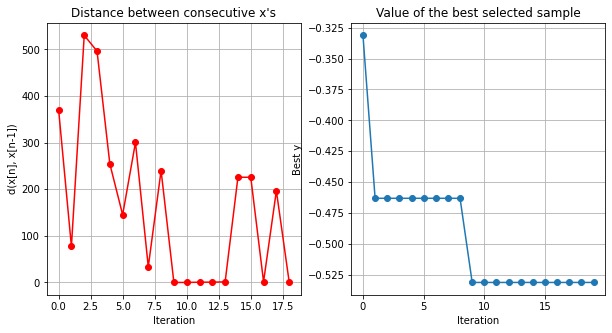

In [ ]:
myBopt_hyp.run_optimization(max_iter = 10)
x_best = myBopt_hyp.x_opt
print(x_best)
myBopt_hyp.plot_convergence()

In [ ]:
print("""
Optimized Parameters:
\t{0}:\t{1}
\t{2}:\t{3}
\t{4}:\t{5}
\t{6}:\t{7}

""".format(bounds[0]["name"],myBopt_hyp.x_opt[0],
           bounds[1]["name"],myBopt_hyp.x_opt[1],
           bounds[3]["name"],myBopt_hyp.x_opt[3],
           bounds[2]["name"],myBopt_hyp.x_opt[2],
))
print("optimized Val_F2Score: {0}".format(-myBopt_hyp.fx_opt))


Optimized Parameters:
	lr:	0.001
	neurons:	256.0
	kernel:	40.41089408226727
	filters:	214.4719274453985


optimized Val_F2Score: 0.5312084885773638


In [ ]:
bounds

[{'domain': (0.1, 0.01, 0.001, 0.0001), 'name': 'lr', 'type': 'discrete'},
 {'domain': (16, 32, 64, 128, 256, 512),
  'name': 'neurons',
  'type': 'discrete'},
 {'domain': (1, 500), 'name': 'filters', 'type': 'continuous'},
 {'domain': (1, 51), 'name': 'kernel', 'type': 'continuous'}]

In [ ]:
myBopt_hyp.x_opt

array([1.00000000e-03, 2.56000000e+02, 2.14471927e+02, 4.04108941e+01])

<h4>Addestriamo il modello sul dataset originale:</h4>

In [ ]:
kfold = StratifiedKFold(n_splits=3, shuffle=True)
#train scores
cvscores_train_loss = []
cvscores_train_auc = []
cvscores_train_rec = []
cvscores_train_prec = []

#validation scores
cvscores_val_loss = []
cvscores_val_auc = []
cvscores_val_rec = []
cvscores_val_prec = []

for train, test in kfold.split(X,Y):    
    
    modello = Sequential()
    modello.add(Dropout(0.25))
    modello.add(Conv1D(214, kernel_size=(40), activation='relu', padding = 'same'))
    modello.add(GlobalAveragePooling1D())
    modello.add(Dense(256, activation='relu'))
    modello.add(Dropout(0,5))
    modello.add(Dense(1, activation='sigmoid'))

    early_stopping = EarlyStopping(
                                  monitor='val_loss', min_delta=0, patience=40, verbose=0, mode='auto',
                                  baseline=None, restore_best_weights=True)


    modello.compile(loss=keras.losses.BinaryCrossentropy(),optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=metrics())
    
    history = modello.fit(X[train], Y[train],
                        batch_size=256,
                        epochs=80,
                        verbose=1,
                        callbacks = [early_stopping],
                        validation_data = (X[test], Y[test]))
    
    cvscores_train_loss.append(history.history['loss'][-1])
    cvscores_train_auc.append(history.history['auc'][-1])
    cvscores_train_rec.append(history.history['recall'][-1])   
    cvscores_train_prec.append(history.history['precision'][-1])

    cvscores_val_loss.append(history.history['val_loss'][-1])
    cvscores_val_auc.append(history.history['val_auc'][-1])
    cvscores_val_rec.append(history.history['val_recall'][-1])   
    cvscores_val_prec.append(history.history['val_precision'][-1])

print("Loss: ",np.mean(cvscores_val_loss),' +/- ' ,np.std(cvscores_val_loss))
print("AUC: ",np.mean(cvscores_val_auc),' +/- ',np.std(cvscores_val_auc))
print("Recall: ",np.mean(cvscores_val_rec),' +/- ',np.std(cvscores_val_rec))
print("Precision: ",np.mean(cvscores_val_prec),' +/- ',np.std(cvscores_val_prec))

    

Train on 4304 samples, validate on 2153 samples
Epoch 1/80
4304/4304 [==============================] - 8s 2ms/step - loss: 0.5297 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 3845.0000 - fn: 459.0000 - accuracy: 0.8934 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4261 - val_loss: 0.4441 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1923.0000 - val_fn: 230.0000 - val_accuracy: 0.8932 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3577
Epoch 2/80
4304/4304 [==============================] - 1s 192us/step - loss: 0.4061 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 3845.0000 - fn: 459.0000 - accuracy: 0.8934 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.3869 - val_loss: 0.3813 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1923.0000 - val_fn: 230.0000 - val_accuracy: 0.8932 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4060
Epoch 3/80
4304/4304 [==============================] - 1s 194us/step - loss: 0.3588 - tp: 0.0000e+00 - fp: 0.

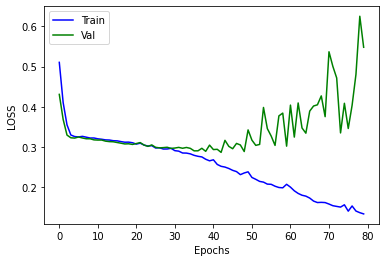

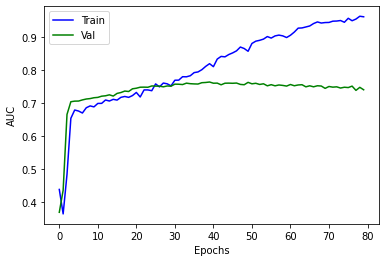

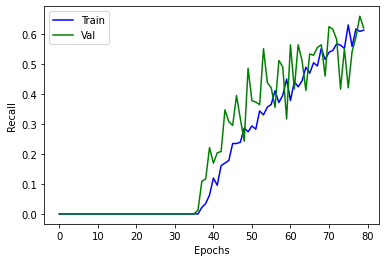

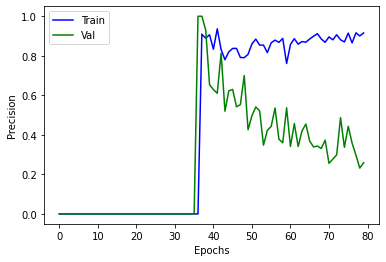

In [ ]:
plot_loss(history)
plot_auc(history)
plot_rec(history)
plot_prec(history)


In [ ]:
y_pred = modello.predict(NR_ER_score_x)
y_pred = y_pred.round()
NR_ER_score_y_int = [int(i) for i in NR_ER_score_y]
print(classification_report(NR_ER_score_y_int,y_pred, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.95      0.78      0.86       465
           1       0.24      0.64      0.34        50

    accuracy                           0.76       515
   macro avg       0.59      0.71      0.60       515
weighted avg       0.88      0.76      0.81       515



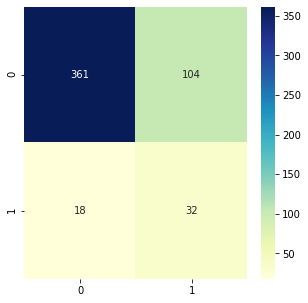

In [ ]:
cm = confusion_matrix(NR_ER_score_y_int,y_pred)
plt.subplots(figsize=(5,5))
sbn.heatmap(cm, annot=True,fmt='g',cmap="YlGnBu")

In [ ]:
history_score = modello.evaluate(NR_ER_score_x,NR_ER_score_y)
print("""Evaluation metrics:
\t{0}:\t{1}
\t{2}:\t{3}
\t{4}:\t{5}
\t{6}:\t{7}
\t{8}:\t{9}
\t{10}:\t{11}
\t{12}:\t{13}
\t{14}:\t{15}
\t{16}:\t{17}
""".format(modello.metrics_names[0],history_score[0],
           modello.metrics_names[1],history_score[1],
           modello.metrics_names[2],history_score[2],
           modello.metrics_names[3],history_score[3],
           modello.metrics_names[4],history_score[4],
           modello.metrics_names[5],history_score[5],
           modello.metrics_names[6],history_score[6],
           modello.metrics_names[7],history_score[7],
           modello.metrics_names[8],history_score[8]
          
          
))

515/515 [==============================] - 0s 157us/step
Evaluation metrics:
	loss:	0.5508986888579952
	tp:	32.0
	fp:	104.0
	tn:	361.0
	fn:	18.0
	accuracy:	0.7631068229675293
	precision:	0.23529411852359772
	recall:	0.6399999856948853
	auc:	0.7254194021224976



<h4>Addestriamo il modello sul dataset SMOTE:</h4>

In [ ]:
X_reshape = X.reshape(-1,16800)
sm = SMOTENC(categorical_features=[0, 41],random_state=0, sampling_strategy='minority',  k_neighbors=3)
X_res, y_res = sm.fit_resample(X_reshape, Y)
X_res = X_res.reshape(-1,400,42)

In [ ]:
kfold = StratifiedKFold(n_splits=3, shuffle=True)
#train scores
cvscores_train_loss = []
cvscores_train_auc = []
cvscores_train_rec = []
cvscores_train_prec = []

#validation scores
cvscores_val_loss = []
cvscores_val_auc = []
cvscores_val_rec = []
cvscores_val_prec = []

for train, test in kfold.split(X_res,y_res):    
    
    modello = Sequential()
    modello.add(Dropout(0.25))
    modello.add(Conv1D(214, kernel_size=(40), activation='relu', padding = 'same'))
    modello.add(GlobalAveragePooling1D())
    modello.add(Dense(256, activation='relu'))
    modello.add(Dropout(0,5))
    modello.add(Dense(1, activation='sigmoid'))

    early_stopping = EarlyStopping(
                                  monitor='val_loss', min_delta=0, patience=40, verbose=0, mode='auto',
                                  baseline=None, restore_best_weights=True)


    modello.compile(loss=keras.losses.BinaryCrossentropy(),optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=metrics())
    
    history = modello.fit(X_res[train], y_res[train],
                        batch_size=256,
                        epochs=80,
                        verbose=1,
                        callbacks = [early_stopping],
                        validation_data = (X_res[test], y_res[test]))
    
    cvscores_train_loss.append(history.history['loss'][-1])
    cvscores_train_auc.append(history.history['auc'][-1])
    cvscores_train_rec.append(history.history['recall'][-1])   
    cvscores_train_prec.append(history.history['precision'][-1])

    cvscores_val_loss.append(history.history['val_loss'][-1])
    cvscores_val_auc.append(history.history['val_auc'][-1])
    cvscores_val_rec.append(history.history['val_recall'][-1])   
    cvscores_val_prec.append(history.history['val_precision'][-1])

print("Loss: ",np.mean(cvscores_val_loss),' +/- ' ,np.std(cvscores_val_loss))
print("AUC: ",np.mean(cvscores_val_auc),' +/- ',np.std(cvscores_val_auc))
print("Recall: ",np.mean(cvscores_val_rec),' +/- ',np.std(cvscores_val_rec))
print("Precision: ",np.mean(cvscores_val_prec),' +/- ',np.std(cvscores_val_prec))

    

Train on 7690 samples, validate on 3846 samples
Epoch 1/80
7690/7690 [==============================] - 5s 623us/step - loss: 0.6600 - tp: 2492.0000 - fp: 1462.0000 - tn: 2383.0000 - fn: 1353.0000 - accuracy: 0.6339 - precision: 0.6302 - recall: 0.6481 - auc: 0.6646 - val_loss: 0.6332 - val_tp: 1295.0000 - val_fp: 684.0000 - val_tn: 1239.0000 - val_fn: 628.0000 - val_accuracy: 0.6589 - val_precision: 0.6544 - val_recall: 0.6734 - val_auc: 0.7038
Epoch 2/80
7690/7690 [==============================] - 3s 442us/step - loss: 0.6248 - tp: 2479.0000 - fp: 1251.0000 - tn: 2594.0000 - fn: 1366.0000 - accuracy: 0.6597 - precision: 0.6646 - recall: 0.6447 - auc: 0.7151 - val_loss: 0.6295 - val_tp: 1404.0000 - val_fp: 796.0000 - val_tn: 1127.0000 - val_fn: 519.0000 - val_accuracy: 0.6581 - val_precision: 0.6382 - val_recall: 0.7301 - val_auc: 0.7159
Epoch 3/80
7690/7690 [==============================] - 3s 440us/step - loss: 0.6099 - tp: 2523.0000 - fp: 1196.0000 - tn: 2649.0000 - fn: 1322.0000

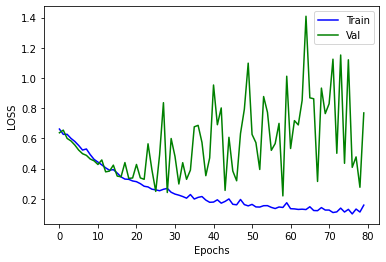

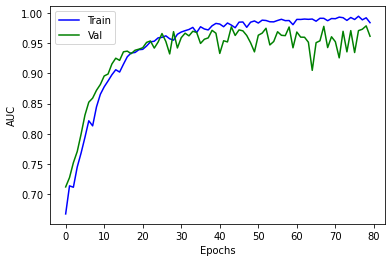

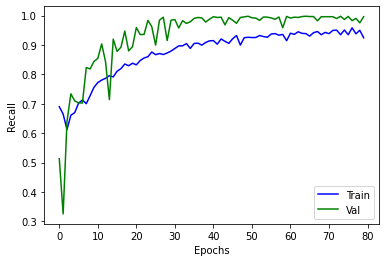

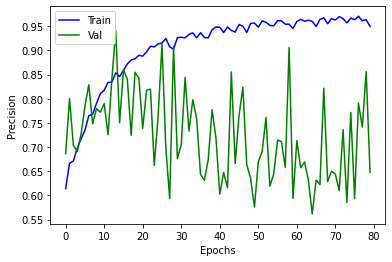

In [ ]:
plot_loss(history)
plot_auc(history)
plot_rec(history)
plot_prec(history)


In [ ]:
y_pred = modello.predict(NR_ER_score_x)
y_pred = y_pred.round()
NR_ER_score_y_int = [int(i) for i in NR_ER_score_y]
print(classification_report(NR_ER_score_y_int,y_pred, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.95      0.45      0.62       465
           1       0.14      0.80      0.23        50

    accuracy                           0.49       515
   macro avg       0.55      0.63      0.42       515
weighted avg       0.88      0.49      0.58       515



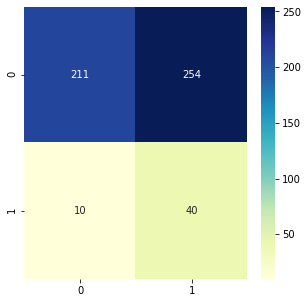

In [ ]:
cm = confusion_matrix(NR_ER_score_y_int,y_pred)
plt.subplots(figsize=(5,5))
sbn.heatmap(cm, annot=True,fmt='g',cmap="YlGnBu")

In [ ]:
history_score = modello.evaluate(NR_ER_score_x,NR_ER_score_y)
print("""Evaluation metrics:
\t{0}:\t{1}
\t{2}:\t{3}
\t{4}:\t{5}
\t{6}:\t{7}
\t{8}:\t{9}
\t{10}:\t{11}
\t{12}:\t{13}
\t{14}:\t{15}
\t{16}:\t{17}
""".format(modello.metrics_names[0],history_score[0],
           modello.metrics_names[1],history_score[1],
           modello.metrics_names[2],history_score[2],
           modello.metrics_names[3],history_score[3],
           modello.metrics_names[4],history_score[4],
           modello.metrics_names[5],history_score[5],
           modello.metrics_names[6],history_score[6],
           modello.metrics_names[7],history_score[7],
           modello.metrics_names[8],history_score[8]
          
          
))

515/515 [==============================] - 0s 252us/step
Evaluation metrics:
	loss:	1.4781919203336957
	tp:	40.0
	fp:	254.0
	tn:	211.0
	fn:	10.0
	accuracy:	0.48737862706184387
	precision:	0.13605442643165588
	recall:	0.800000011920929
	auc:	0.7122796177864075



<h3>4) Funzione da ottimizzare: F1Score</h3>

In [ ]:
def create_model(filters,kernel,lr,neurons):
    
    modello = Sequential()
    modello.add(Dropout(0.25))
    modello.add(Conv1D(filters, kernel_size=(kernel), activation='relu', padding = 'same'))
    modello.add(GlobalAveragePooling1D())
    modello.add(Dense(neurons, activation='relu'))
    modello.add(Dropout(0,5))
    modello.add(Dense(1, activation='sigmoid'))

    modello.compile(loss=keras.losses.BinaryCrossentropy(),optimizer=keras.optimizers.Adam(learning_rate=lr), metrics=metrics())

    return(modello)

In [ ]:
def model_fit(filters,kernel,lr,neurons):

    X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,stratify=Y)
    model = create_model(filters,kernel,lr,neurons)

    early_stopping = EarlyStopping(
                              monitor='val_loss', min_delta=0, patience=20, verbose=0, mode='auto',
                              baseline=None, restore_best_weights=True)
    history = model.fit(X_train, y_train,
                      batch_size=256,
                      epochs=80,
                      verbose=1,
                      callbacks = [early_stopping],
                      validation_data=(X_test, y_test),
                      )
    
    try:
        evaluation = (2*history.history['val_precision'][-1]*history.history['val_recall'][-1])/((history.history['val_precision'][-1])+history.history['val_recall'][-1])
    except:
        evaluation = 0
      

    print("Optimized Parameters:\n ")
    print( 'lr '+str(lr)+'\n')
    print( 'filters '+str(filters)+'\n')
    print( 'kernel '+str(kernel)+'\n')
    print( 'neurons '+str(neurons)+'\n')


    return(evaluation)

In [ ]:
def f(x):
    evaluation = model_fit(

      lr = float(x[:,0]),
      neurons = int(x[:,1]),
      filters = int(x[:,2]), 
      kernel = int(x[:,3])
       )
    score = evaluation
    print('Val_F1Score: ' + str(score))
    return(-score)

In [ ]:
bounds = [
          {'name': 'lr', 'type': 'discrete', 'domain': (0.1,0.01,0.001,0.0001)},
          {'name': 'neurons', 'type': 'discrete', 'domain': (16,32,64,128,256,512)},
          {'name': 'filters', 'type': 'continuous', 'domain': (1,500)},
          {'name': 'kernel', 'type': 'continuous', 'domain': (1,51)},
          ]


In [ ]:
myBopt_hyp =GPyOpt.methods.BayesianOptimization(f=f,domain=bounds,initial_design_numdata = 10,model_type="GP_MCMC",acquisition_type='EI_MCMC')   

Train on 5165 samples, validate on 1292 samples
Epoch 1/80
5165/5165 [==============================] - 7s 1ms/step - loss: 0.6882 - tp: 64.0000 - fp: 483.0000 - tn: 4131.0000 - fn: 487.0000 - accuracy: 0.8122 - precision: 0.1170 - recall: 0.1162 - auc: 0.4733 - val_loss: 0.6809 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1154.0000 - val_fn: 138.0000 - val_accuracy: 0.8932 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3857
Epoch 2/80
5165/5165 [==============================] - 1s 141us/step - loss: 0.6733 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4614.0000 - fn: 551.0000 - accuracy: 0.8933 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4117 - val_loss: 0.6635 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1154.0000 - val_fn: 138.0000 - val_accuracy: 0.8932 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3809
Epoch 3/80
5165/5165 [==============================] - 1s 142us/step - loss: 0.6521 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn

reconstraining parameters GP_regression.rbf
reconstraining parameters GP_regression.Gaussian_noise.variance


Train on 5165 samples, validate on 1292 samples
Epoch 1/80
5165/5165 [==============================] - 1s 247us/step - loss: 0.3846 - tp: 0.0000e+00 - fp: 6.0000 - tn: 4608.0000 - fn: 551.0000 - accuracy: 0.8922 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5145 - val_loss: 0.3365 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1154.0000 - val_fn: 138.0000 - val_accuracy: 0.8932 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6933
Epoch 2/80
5165/5165 [==============================] - 1s 181us/step - loss: 0.3408 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4614.0000 - fn: 551.0000 - accuracy: 0.8933 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5766 - val_loss: 0.3330 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1154.0000 - val_fn: 138.0000 - val_accuracy: 0.8932 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7040
Epoch 3/80
5165/5165 [==============================] - 1s 181us/step - loss: 0.3281 - tp: 0.0000e+00 - fp: 0.00

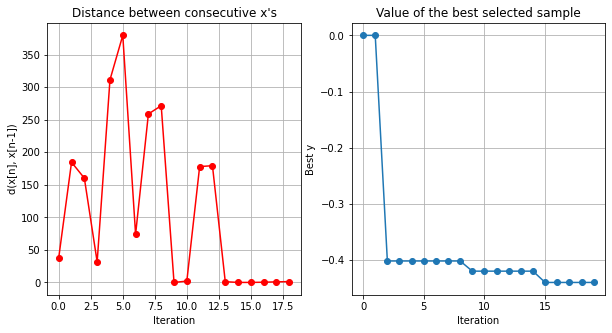

In [ ]:
myBopt_hyp.run_optimization(max_iter = 10)
x_best = myBopt_hyp.x_opt
print(x_best)
myBopt_hyp.plot_convergence()

In [ ]:
print("""
Optimized Parameters:
\t{0}:\t{1}
\t{2}:\t{3}
\t{4}:\t{5}
\t{6}:\t{7}

""".format(bounds[0]["name"],myBopt_hyp.x_opt[0],
           bounds[1]["name"],myBopt_hyp.x_opt[1],
           bounds[3]["name"],myBopt_hyp.x_opt[3],
           bounds[2]["name"],myBopt_hyp.x_opt[2],
))
print("optimized Val_F1Score: {0}".format(-myBopt_hyp.fx_opt))


Optimized Parameters:
	lr:	0.01
	neurons:	256.0
	kernel:	22.933436224446123
	filters:	306.87785773019493


optimized Val_F1Score: 0.4399999996185302


In [ ]:
bounds

[{'domain': (0.1, 0.01, 0.001, 0.0001), 'name': 'lr', 'type': 'discrete'},
 {'domain': (16, 32, 64, 128, 256, 512),
  'name': 'neurons',
  'type': 'discrete'},
 {'domain': (1, 500), 'name': 'filters', 'type': 'continuous'},
 {'domain': (1, 51), 'name': 'kernel', 'type': 'continuous'}]

In [ ]:
myBopt_hyp.x_opt

array([1.00000000e-02, 2.56000000e+02, 3.06877858e+02, 2.29334362e+01])

In [ ]:
kfold = StratifiedKFold(n_splits=3, shuffle=True)
#train scores
cvscores_train_loss = []
cvscores_train_auc = []
cvscores_train_rec = []
cvscores_train_prec = []

#validation scores
cvscores_val_loss = []
cvscores_val_auc = []
cvscores_val_rec = []
cvscores_val_prec = []

for train, test in kfold.split(X,Y):    
    
    modello = Sequential()
    modello.add(Dropout(0.25))
    modello.add(Conv1D(307, kernel_size=(23), activation='relu', padding = 'same'))
    modello.add(GlobalAveragePooling1D())
    modello.add(Dense(256, activation='relu'))
    modello.add(Dropout(0,5))
    modello.add(Dense(1, activation='sigmoid'))

    early_stopping = EarlyStopping(
                                  monitor='val_loss', min_delta=0, patience=40, verbose=0, mode='auto',
                                  baseline=None, restore_best_weights=True)


    modello.compile(loss=keras.losses.BinaryCrossentropy(),optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=metrics())
    
    history = modello.fit(X[train], Y[train],
                        batch_size=256,
                        epochs=80,
                        verbose=1,
                        callbacks = [early_stopping],
                        validation_data = (X[test], Y[test]))
    
    cvscores_train_loss.append(history.history['loss'][-1])
    cvscores_train_auc.append(history.history['auc'][-1])
    cvscores_train_rec.append(history.history['recall'][-1])   
    cvscores_train_prec.append(history.history['precision'][-1])

    cvscores_val_loss.append(history.history['val_loss'][-1])
    cvscores_val_auc.append(history.history['val_auc'][-1])
    cvscores_val_rec.append(history.history['val_recall'][-1])   
    cvscores_val_prec.append(history.history['val_precision'][-1])

print("Loss: ",np.mean(cvscores_val_loss),' +/- ' ,np.std(cvscores_val_loss))
print("AUC: ",np.mean(cvscores_val_auc),' +/- ',np.std(cvscores_val_auc))
print("Recall: ",np.mean(cvscores_val_rec),' +/- ',np.std(cvscores_val_rec))
print("Precision: ",np.mean(cvscores_val_prec),' +/- ',np.std(cvscores_val_prec))

    

Train on 4304 samples, validate on 2153 samples
Epoch 1/80
4304/4304 [==============================] - 3s 676us/step - loss: 0.3902 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 3845.0000 - fn: 459.0000 - accuracy: 0.8934 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5061 - val_loss: 0.3321 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1923.0000 - val_fn: 230.0000 - val_accuracy: 0.8932 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6814
Epoch 2/80
4304/4304 [==============================] - 1s 210us/step - loss: 0.3295 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 3845.0000 - fn: 459.0000 - accuracy: 0.8934 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6509 - val_loss: 0.3254 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1923.0000 - val_fn: 230.0000 - val_accuracy: 0.8932 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6883
Epoch 3/80
4304/4304 [==============================] - 1s 212us/step - loss: 0.3238 - tp: 0.0000e+00 - fp: 

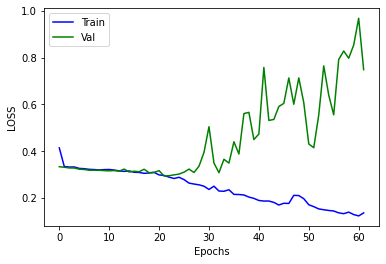

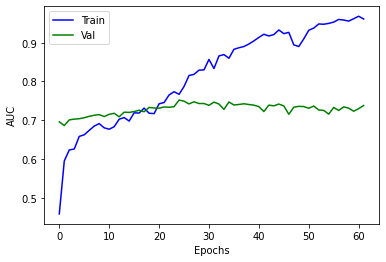

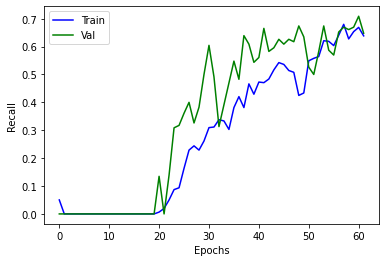

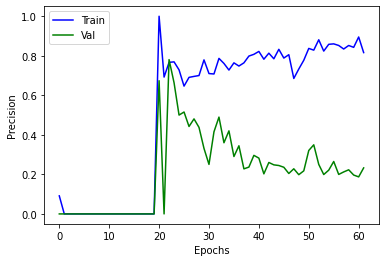

In [ ]:
plot_loss(history)
plot_auc(history)
plot_rec(history)
plot_prec(history)


In [ ]:
y_pred = modello.predict(NR_ER_score_x)
y_pred = y_pred.round()
NR_ER_score_y_int = [int(i) for i in NR_ER_score_y]
print(classification_report(NR_ER_score_y_int,y_pred, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95       465
           1       0.00      0.00      0.00        50

    accuracy                           0.90       515
   macro avg       0.45      0.50      0.47       515
weighted avg       0.82      0.90      0.86       515



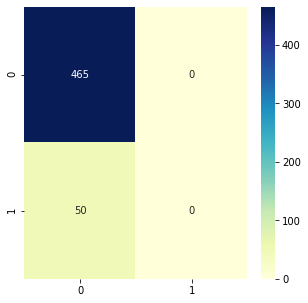

In [ ]:
cm = confusion_matrix(NR_ER_score_y_int,y_pred)
plt.subplots(figsize=(5,5))
sbn.heatmap(cm, annot=True,fmt='g',cmap="YlGnBu")

In [ ]:
history_score = modello.evaluate(NR_ER_score_x,NR_ER_score_y)
print("""Evaluation metrics:
\t{0}:\t{1}
\t{2}:\t{3}
\t{4}:\t{5}
\t{6}:\t{7}
\t{8}:\t{9}
\t{10}:\t{11}
\t{12}:\t{13}
\t{14}:\t{15}
\t{16}:\t{17}
""".format(modello.metrics_names[0],history_score[0],
           modello.metrics_names[1],history_score[1],
           modello.metrics_names[2],history_score[2],
           modello.metrics_names[3],history_score[3],
           modello.metrics_names[4],history_score[4],
           modello.metrics_names[5],history_score[5],
           modello.metrics_names[6],history_score[6],
           modello.metrics_names[7],history_score[7],
           modello.metrics_names[8],history_score[8]
          
          
))

515/515 [==============================] - 0s 186us/step
Evaluation metrics:
	loss:	0.2855819171421157
	tp:	0.0
	fp:	0.0
	tn:	465.0
	fn:	50.0
	accuracy:	0.9029126167297363
	precision:	0.0
	recall:	0.0
	auc:	0.7309678196907043



<h4>Addestramento del modello su dataset SMOTE:</h4>

In [ ]:
X_reshape = X.reshape(-1,16800)
sm = SMOTENC(categorical_features=[0, 41],random_state=0, sampling_strategy='minority',  k_neighbors=3)
X_res, y_res = sm.fit_resample(X_reshape, Y)
X_res = X_res.reshape(-1,400,42)

In [ ]:
kfold = StratifiedKFold(n_splits=3, shuffle=True)
#train scores
cvscores_train_loss = []
cvscores_train_auc = []
cvscores_train_rec = []
cvscores_train_prec = []

#validation scores
cvscores_val_loss = []
cvscores_val_auc = []
cvscores_val_rec = []
cvscores_val_prec = []

for train, test in kfold.split(X_res,y_res):    
    
    modello = Sequential()
    modello.add(Dropout(0.25))
    modello.add(Conv1D(276, kernel_size=(34), activation='relu', padding = 'same'))
    modello.add(GlobalAveragePooling1D())
    modello.add(Dense(256, activation='relu'))
    modello.add(Dropout(0,5))
    modello.add(Dense(1, activation='sigmoid'))
0 EPOCHE
    early_stopping = EarlyStopping(
                                  monitor='val_loss', min_delta=0, patience=40, verbose=0, mode='auto',
                                  baseline=None, restore_best_weights=True)


    modello.compile(loss=keras.losses.BinaryCrossentropy(),optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=metrics())
    
    history = modello.fit(X_res[train], y_res[train],
                        batch_size=256,
                        epochs=80,
                        verbose=1,
                        callbacks = [early_stopping],
                        validation_data = (X_res[test], y_res[test]))
    
    cvscores_train_loss.append(history.history['loss'][-1])
    cvscores_train_auc.append(history.history['auc'][-1])
    cvscores_train_rec.append(history.history['recall'][-1])   
    cvscores_train_prec.append(history.history['precision'][-1])

    cvscores_val_loss.append(history.history['val_loss'][-1])
    cvscores_val_auc.append(history.history['val_auc'][-1])
    cvscores_val_rec.append(history.history['val_recall'][-1])   
    cvscores_val_prec.append(history.history['val_precision'][-1])

print("Loss: ",np.mean(cvscores_val_loss),' +/- ' ,np.std(cvscores_val_loss))
print("AUC: ",np.mean(cvscores_val_auc),' +/- ',np.std(cvscores_val_auc))
print("Recall: ",np.mean(cvscores_val_rec),' +/- ',np.std(cvscores_val_rec))
print("Precision: ",np.mean(cvscores_val_prec),' +/- ',np.std(cvscores_val_prec))

    

Train on 7690 samples, validate on 3846 samples
Epoch 1/80
7690/7690 [==============================] - 2s 317us/step - loss: 0.6724 - tp: 1934.0000 - fp: 1191.0000 - tn: 2654.0000 - fn: 1911.0000 - accuracy: 0.5966 - precision: 0.6189 - recall: 0.5030 - auc: 0.6403 - val_loss: 0.6498 - val_tp: 872.0000 - val_fp: 351.0000 - val_tn: 1572.0000 - val_fn: 1051.0000 - val_accuracy: 0.6355 - val_precision: 0.7130 - val_recall: 0.4535 - val_auc: 0.6977
Epoch 2/80
7690/7690 [==============================] - 2s 247us/step - loss: 0.6300 - tp: 2379.0000 - fp: 1119.0000 - tn: 2726.0000 - fn: 1466.0000 - accuracy: 0.6638 - precision: 0.6801 - recall: 0.6187 - auc: 0.7149 - val_loss: 0.6328 - val_tp: 1452.0000 - val_fp: 893.0000 - val_tn: 1030.0000 - val_fn: 471.0000 - val_accuracy: 0.6453 - val_precision: 0.6192 - val_recall: 0.7551 - val_auc: 0.7152
Epoch 3/80
7690/7690 [==============================] - 2s 246us/step - loss: 0.6103 - tp: 2610.0000 - fp: 1196.0000 - tn: 2649.0000 - fn: 1235.0000

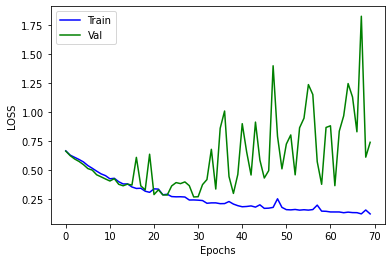

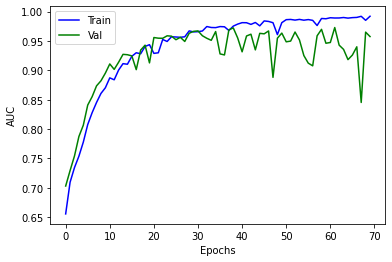

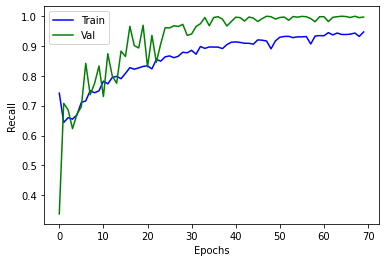

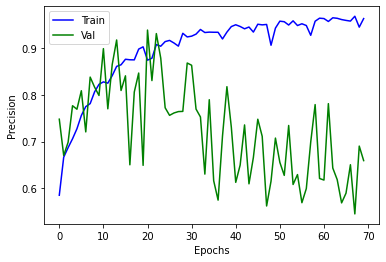

In [ ]:
plot_loss(history)
plot_auc(history)
plot_rec(history)
plot_prec(history)


In [ ]:
y_pred = modello.predict(NR_ER_score_x)
y_pred = y_pred.round()
NR_ER_score_y_int = [int(i) for i in NR_ER_score_y]
print(classification_report(NR_ER_score_y_int,y_pred, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.94      0.85      0.89       465
           1       0.25      0.46      0.32        50

    accuracy                           0.81       515
   macro avg       0.59      0.66      0.61       515
weighted avg       0.87      0.81      0.84       515



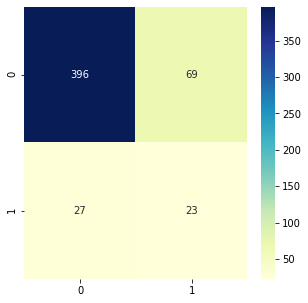

In [ ]:
cm = confusion_matrix(NR_ER_score_y_int,y_pred)
plt.subplots(figsize=(5,5))
sbn.heatmap(cm, annot=True,fmt='g',cmap="YlGnBu")

In [ ]:
history_score = modello.evaluate(NR_ER_score_x,NR_ER_score_y)
print("""Evaluation metrics:
\t{0}:\t{1}
\t{2}:\t{3}
\t{4}:\t{5}
\t{6}:\t{7}
\t{8}:\t{9}
\t{10}:\t{11}
\t{12}:\t{13}
\t{14}:\t{15}
\t{16}:\t{17}
""".format(modello.metrics_names[0],history_score[0],
           modello.metrics_names[1],history_score[1],
           modello.metrics_names[2],history_score[2],
           modello.metrics_names[3],history_score[3],
           modello.metrics_names[4],history_score[4],
           modello.metrics_names[5],history_score[5],
           modello.metrics_names[6],history_score[6],
           modello.metrics_names[7],history_score[7],
           modello.metrics_names[8],history_score[8]
          
          
))

515/515 [==============================] - 0s 192us/step
Evaluation metrics:
	loss:	0.44581279662048934
	tp:	23.0
	fp:	69.0
	tn:	396.0
	fn:	27.0
	accuracy:	0.813592255115509
	precision:	0.25
	recall:	0.46000000834465027
	auc:	0.696086049079895

